# Проект по HR - аналитике

**Описание проекта**

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.
Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 
Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли.

**Задача 1** - построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

**Задача 2** - построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

# ЗАДАЧА 1

**Описание данных:**
    
Для этой задачи заказчик предоставил данные с признаками:

- id — уникальный идентификатор сотрудника;
- dept — отдел, в котором работает сотрудник;
- level — уровень занимаемой должности;
- workload — уровень загруженности сотрудника;
- employment_years — длительность работы в компании (в годах);
- last_year_promo — показывает, было ли повышение за последний год;
- last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
- supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
- salary — ежемесячная зарплата сотрудника;
- job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.

## Загрузка данных

### Загрузка и предварительный анализ данных

In [1]:
#установки
!pip install shap
!pip install phik
!pip install -U scikit-learn 
!pip install --upgrade matplotlib
!pip uninstall seaborn Pillow ydata-profiling -y
!pip install seaborn Pillow ydata-profiling
!pip uninstall seaborn -y
!pip install seaborn
!pip cache purge

Found existing installation: seaborn 0.13.2
Uninstalling seaborn-0.13.2:
  Successfully uninstalled seaborn-0.13.2
Found existing installation: pillow 10.4.0
Uninstalling pillow-10.4.0:
  Successfully uninstalled pillow-10.4.0
Found existing installation: ydata-profiling 4.9.0
Uninstalling ydata-profiling-4.9.0:
  Successfully uninstalled ydata-profiling-4.9.0
     |████████████████████████████████| 294 kB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 4.5 MB 23.1 MB/s eta 0:00:01
     |████████████████████████████████| 356 kB 86.2 MB/s eta 0:00:01
Found existing installation: seaborn 0.13.2
Uninstalling seaborn-0.13.2:
  Successfully uninstalled seaborn-0.13.2
  Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Files removed: 8


In [2]:
# Импорт стандартных библиотек
import pandas as pd
import numpy as np

# Импорт библиотек для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

# Импорт библиотек для машинного обучения и обработки данных
from sklearn.model_selection import  RandomizedSearchCV, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.metrics import confusion_matrix, roc_auc_score, make_scorer, mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier, DummyRegressor

# Импорт библиотек для анализа данных
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy.stats import ttest_ind
import shap
import phik

In [4]:
train_job.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [5]:
#посмотрим информацию о датафрейме train_job
train_job.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [6]:
# посмотрим на пропущенные значения каждого столбца
train_job.isna().sum()

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

Данные представляют собой таблицу с 4000 записями и 10 столбцами. Пять столбцов имеют числовой тип данных (int64, float), остальные 5  - строковый тип данных (object). Тип данных столбцов соответствует информации, представленной в них. В столбцах 'dept' и 'level' есть пропуски, но незначительные (6 и 4), которые можно будет удалить на этапе паплайна.

In [8]:
test_job.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [9]:
#посмотрим информацию о датафрейме test_job
test_job.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [10]:
test_job.isna().sum()

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

Данные представляют собой таблицу с 2000 записями и 9 столбцами. Четыре столбца имеют числовой тип данных (int64), остальные 5  - строковый тип данных (object). Тип данных столбцов соответствует информации, представленной в них. В столбцах 'dept' и 'level' есть пропуски, но незначительные (2 и 2), которые можно будет удалить на этапе паплайна.

In [12]:
test_target.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [13]:
test_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


In [14]:
# посмотрим на пропущенные значения каждого столбца
test_target.isna().sum()

id                       0
job_satisfaction_rate    0
dtype: int64

Данные представляют собой таблицу с 2000 записями и 2 столбцами. Два столбца имеет числовой тип данных (int64, float). Тип данных столбцов соответствует информации, представленной в них. Пропусков в данных не обнаружено

##  Предобработка данных

In [15]:
#объединим 2 части тестовых данных 
test_job = pd.merge(test_job, test_target, on='id', how='inner')

In [16]:
test_job.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   1998 non-null   object 
 2   level                  1999 non-null   object 
 3   workload               2000 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
 9   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 156.4+ KB


### Определение наличия явных и неявных дубликатов

####  Определения наличия явных дубликатов

In [17]:
# проверим наличие явных дубликатов в датафрейме train_job
train_job.duplicated().sum()

0

Явных дубликатов не обнаружено

In [18]:
# проверим наличие явных дубликатов в датафрейме test_job
test_job.duplicated().sum()

0

Явных дубликатов не обнаружено

#### Определение наличия неявных дубликатов

Теперь проверим неявные дубликаты в датасете train_job

In [19]:
# Проверим на дубликаты по выбранной комбинации столбцов для train_job
duplicate_rows = train_job.duplicated(subset=['id', 'dept', 'level', 'workload', 'employment_years'], keep=False)

In [20]:
train_job[duplicate_rows]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate


In [21]:
# Проверим на дубликаты по выбранной комбинации столбцов для test_job
duplicate_rows2 = test_job.duplicated(subset=['id', 'dept', 'level', 'workload', 'employment_years'], keep=False)

In [22]:
test_job[duplicate_rows2]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate


Неявных дубликатов не обнаружено

####  Анализ столбцов категориальных данных

In [23]:
train_job.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [24]:
#выведем на экран все уникальные значения столбца 'dept'
train_job['dept'].unique()

array(['sales', 'hr', 'technology', 'purchasing', 'marketing', nan],
      dtype=object)

В датасете представлены данные для 5 отделов: 'sales', 'hr', 'technology', 'purchasing', 'marketing'. Также есть nan, которые предполагаются обработать в паплайне.

In [25]:
#выведем на экран все уникальные значения столбца 'level'
train_job['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

In [26]:
#поправим sinior на senior
train_job['level'] = train_job['level'].replace('sinior', 'senior')

Также есть nan, которые предполагаются обработать в паплайне.

In [27]:
#проверим
train_job['level'].unique()

array(['junior', 'middle', 'senior', nan], dtype=object)

В датасете сотрудники поделены на 3 уровня: 'junior', 'middle', 'senior'. Также есть nan, которые предполагаются обработать в паплайне.

In [28]:
#выведем на экран все уникальные значения столбца 'workload'
train_job['workload'].unique()

array(['medium', 'high', 'low'], dtype=object)

В датасете загрузка сотрудников поделена на 3 уровня: 'medium', 'high', 'low'

In [29]:
#выведем на экран все уникальные значения столбца 'last_year_promo'
train_job['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

In [30]:
#выведем на экран все уникальные значения столбца 'last_year_violations'
train_job['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

Теперь посмотрим на датасет test_job

In [31]:
#выведем на экран все уникальные значения столбца 'dept'
test_job['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' '],
      dtype=object)

In [32]:
test_job['dept'].value_counts()

dept
sales         763
technology    455
marketing     279
purchasing    273
hr            227
                1
Name: count, dtype: int64

Судя по всему, 1 значение у нас отнечено к категории " ". 

In [33]:
#выведем на экран все уникальные значения столбца 'workload'
test_job['workload'].unique()

array(['medium', 'low', 'high', ' '], dtype=object)

Судя по всему, 1 значение у нас отнечено к категории " ". 

In [34]:
#выведем на экран все уникальные значения столбца 'level'
test_job['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

In [35]:
#заменяем 'sinior' на 'senior'
test_job['level'] = test_job['level'].replace('sinior', 'senior')

In [36]:
#проверим
test_job['level'].unique()

array(['junior', 'middle', 'senior', nan], dtype=object)

In [37]:
#выведем на экран все уникальные значения столбца 'last_year_promo'
test_job['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

In [38]:
#выведем на экран все уникальные значения столбца 'last_year_violations'
test_job['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

In [39]:
test_job.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   1998 non-null   object 
 2   level                  1999 non-null   object 
 3   workload               2000 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
 9   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 156.4+ KB


In [40]:
test_job.isna().sum()

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

## Исследовательский анализ данных

### Статистический анализ признаков

In [41]:
#выведем статистические данные по датасету train_job
train_job.describe()

,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000


Рассмотрим статистические результаты: 1) Средний стаж работы (employment_years) составляет 3.72 года со стандартным отклонением 2.54, что значительно. Минимальный стаж - 1 год, максимальный - 10 лет. 50% сотрудников имеют стаж работы 3 года или меньше, а 25% имеют стаж 2 года или меньше. 2) Средняя оценка руководителя составляет 3.48. Стандартное отклонение (1.01) показывает, что оценки руководителей варьируются, но большинство находятся около среднего значения.Половина сотрудников имеют оценку 4 или выше, а 25% — оценку 3 или ниже. 3) средняя зарплата составляет около 33 953. Стандартное отклонение показывает значительное различие в зарплатах среди сотрудников (14907).  Минимальная зарплата составляет 12 000, максимальная — 98 400. Половина сотрудников получают 30 000 или меньше, а 25% — 22 800 или меньше. 4) Средний уровень удовлетворенности составляет около 53,4%.  Стандартное отклонение показывает умеренное различие в уровне удовлетворенности. Половина сотрудников имеют удовлетворенность 56% или выше, а 25% — 36% или ниже.

In [42]:
#выведем статистические данные по датасету test_job
test_job.describe()

,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000
mean,552765.213500,3.666500,3.526500,34066.800000,0.54878
std,253851.326129,2.537222,0.996892,15398.436729,0.22011
min,100298.000000,1.000000,1.000000,12000.000000,0.03000
25%,339052.000000,1.000000,3.000000,22800.000000,0.38000
50%,550793.000000,3.000000,4.000000,30000.000000,0.58000
75%,765763.750000,6.000000,4.000000,43200.000000,0.72000
max,999029.000000,10.000000,5.000000,96000.000000,1.00000


Рассмотрим статистические результаты: 1) Средний стаж работы (employment_years) составляет 3.67 года со стандартным отклонением 2.54, что значительно. Минимальный стаж - 1 год, максимальный - 10 лет. 50% сотрудников имеют стаж работы 3 года или меньше, а 25% имеют стаж 1 года или меньше. 2) Средняя оценка руководителя составляет 3.52. Стандартное отклонение (1) показывает, что оценки руководителей варьируются, но большинство находятся около среднего значения. Половина сотрудников имеют оценку 4 или выше, а 25% — оценку 3 или ниже. 3) средняя зарплата составляет около 34 085. Стандартное отклонение показывает значительное различие в зарплатах среди сотрудников (14907). Минимальная зарплата составляет 12 000, максимальная — 98 400. Половина сотрудников получают 30 000 или меньше, а 25% — 22 800 или меньше. 4) Средний уровень удовлетворенности составляет около 55%. Стандартное отклонение показывает умеренное различие в уровне удовлетворенности. Половина сотрудников имеют удовлетворенность 58% или выше, а 25% — 38% или ниже.

### Визуализация и анализ количественных и категориальных признаков

In [43]:
#напомним какие столбцы есть в датафрейме train_job
train_job.head(2)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76


In [44]:
#напишем функцию для построения гистограммы для каждого количественного признака 
#сначала укажем количественные признаки
quantitative_columns = ['salary', 'job_satisfaction_rate']

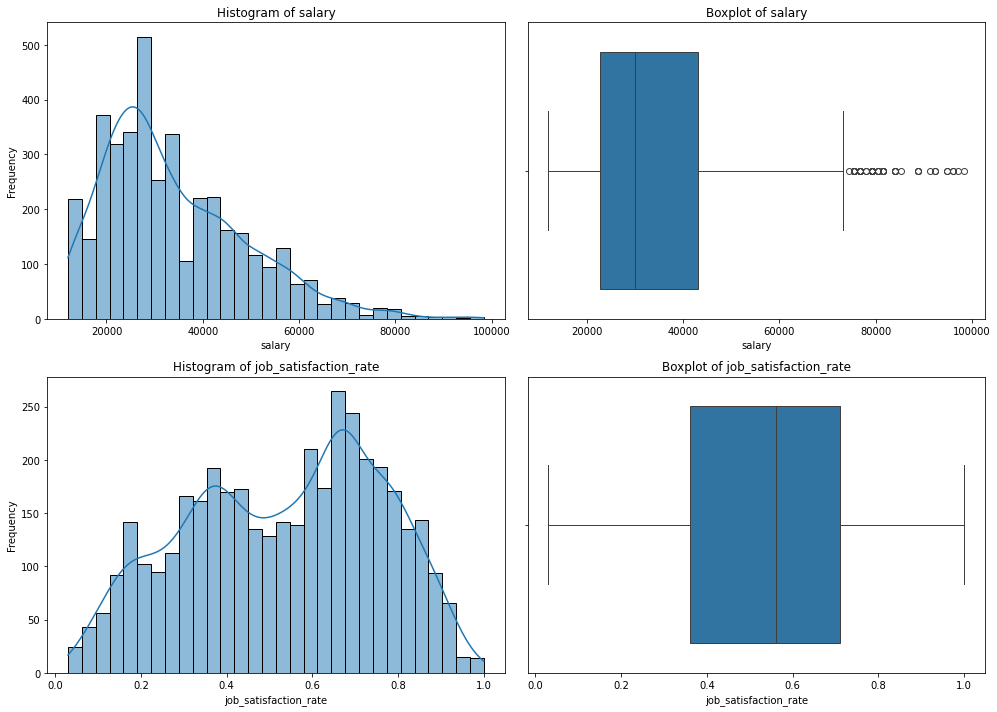

In [45]:
#определим количество строк и столбцов для подграфиков 
num_features = len(quantitative_columns)
fig, axes = plt.subplots(nrows=num_features, ncols=2, figsize=(14, num_features * 5))

#построим графики
for i, column in enumerate(quantitative_columns):
    #построим гистограмму
    sns.histplot(train_job[column], bins = 30, kde =True, ax=axes[i,0])
    axes[i,0].set_title(f'Histogram of {column}')
    axes[i,0].set_xlabel(column)
    axes[i,0].set_ylabel('Frequency')
    
    #построим боксплот
    sns.boxplot(x=train_job[column], ax=axes[i, 1])
    axes[i,1].set_title(f'Boxplot of {column}')
    axes[i,1].set_xlabel(column)
    
plt.tight_layout()
plt.show()

Посмотрим, что можно сказать о характере распределения данных датасета train_job: 1) Данные по ежемесячной зарплате сотрудников варьируются от 12000 до 98400. Можно отметить отклонение от симметрии в данных, распределение скошено влево с пиком в точке 30000. Значения больше ок 7500  выбиваются из общей картины 2) Данные по уровню удовлетворенности сотрудника работой варьируются от 0.03 до 1. В распределении можно ответить два неявных пика (0.4 и 0.7).

In [46]:
train_job.query('salary > 75000')

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
45,538347,technology,senior,high,3,no,no,1,84000,0.21
141,128304,marketing,senior,high,7,no,no,3,80400,0.48
196,486576,marketing,senior,high,9,no,no,4,76800,0.66
360,405345,marketing,senior,high,7,no,no,2,81600,0.58
427,399126,sales,senior,high,2,no,no,2,76800,0.26
1040,301946,hr,senior,high,7,no,no,5,75600,0.75
1203,493024,technology,senior,high,10,no,no,4,79200,0.64
1241,148024,technology,senior,high,4,no,no,4,94800,0.67
1491,796799,marketing,senior,high,4,no,no,3,79200,0.25
1543,775511,sales,senior,high,5,no,yes,3,75600,0.17


Все сотрудники с заработной платой более 75000 - это сотрудники уровня senior

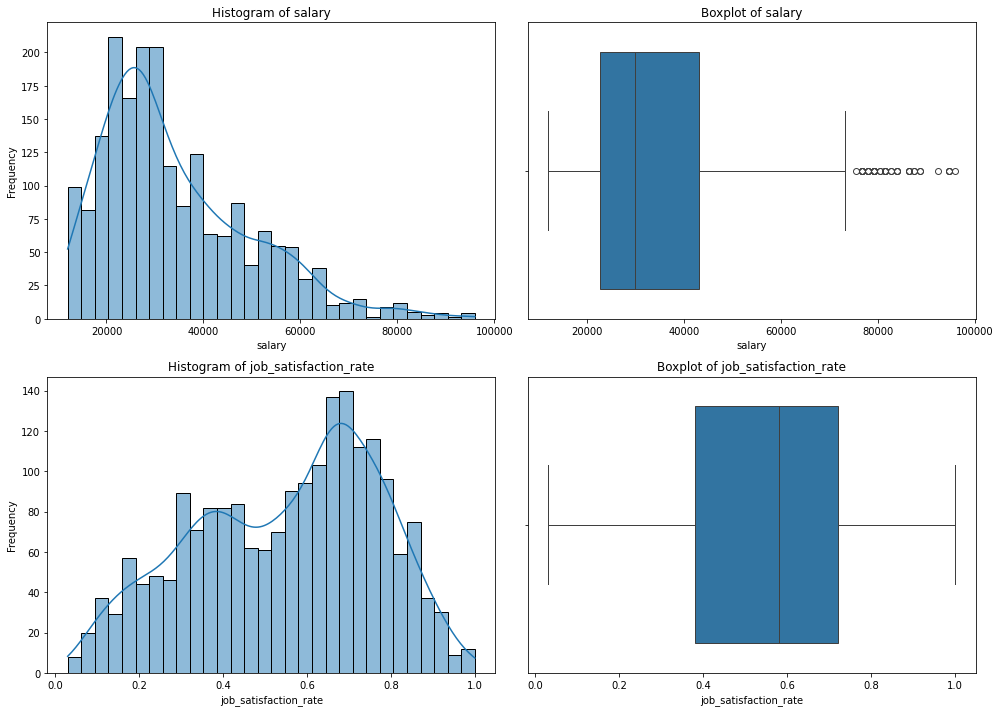

In [47]:
#определим количество строк и столбцов для подграфиков 
num_features = len(quantitative_columns)
fig, axes = plt.subplots(nrows=num_features, ncols=2, figsize=(14, num_features * 5))

#построим графики
for i, column in enumerate(quantitative_columns):
    #построим гистограмму
    sns.histplot(test_job[column], bins = 30, kde =True, ax=axes[i,0])
    axes[i,0].set_title(f'Histogram of {column}')
    axes[i,0].set_xlabel(column)
    axes[i,0].set_ylabel('Frequency')
    
    #построим боксплот
    sns.boxplot(x=test_job[column], ax=axes[i, 1])
    axes[i,1].set_title(f'Boxplot of {column}')
    axes[i,1].set_xlabel(column)
    
plt.tight_layout()
plt.show()

Характер распределения данных датасета test_job похож на train_job: 1) Данные по ежемесячной зарплате сотрудников варьируются от 12000 до 96000. Можно отметить отклонение от симметрии в данных, распределение скошено влево с пиком в точке 30000. Значения больше ок 7500  выбиваются из общей картины  2) Данные по уровню удовлетворенности сотрудника работой варьируются от 0.03 до 1. В распределении можно ответить два неявных пика (0.4 и 0.7).

In [48]:
#напишем функцию для построения гистограммы для каждого категориального признака и дескретных значений
#сначала укажем, какие признаки у нас относятся к категориальным и дискретным значениям
categorical_disc_columns = ['dept','level', 'workload', 'employment_years', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation']

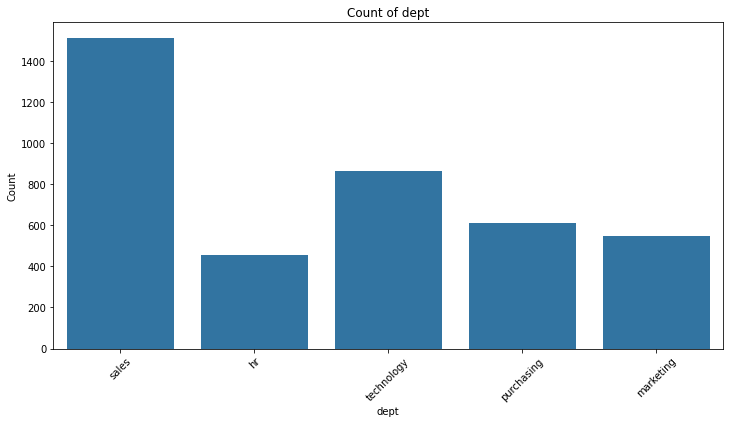

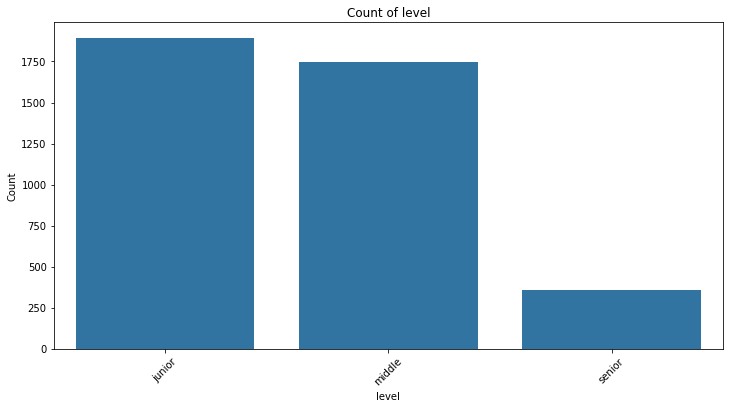

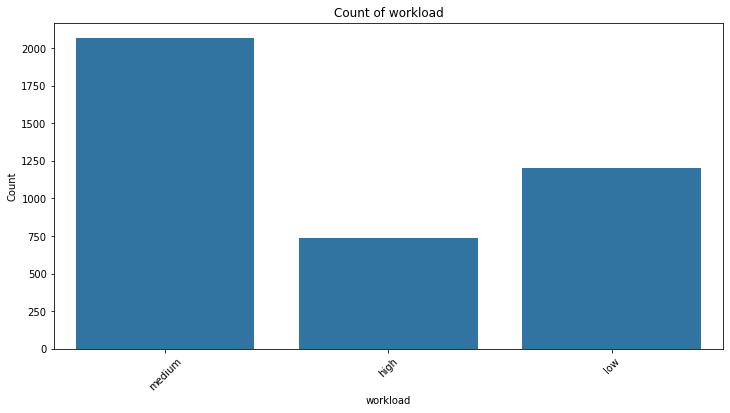

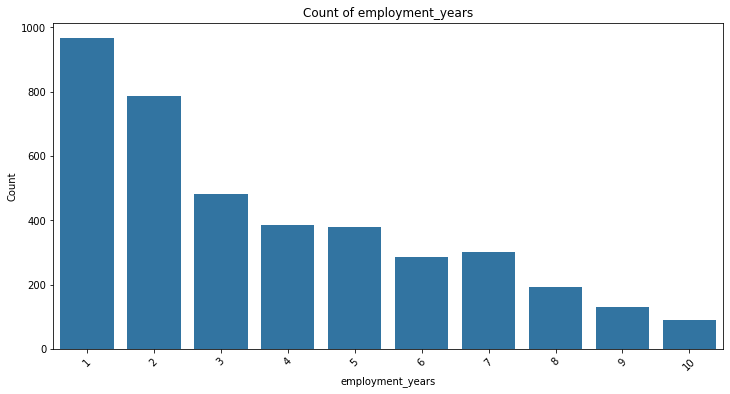

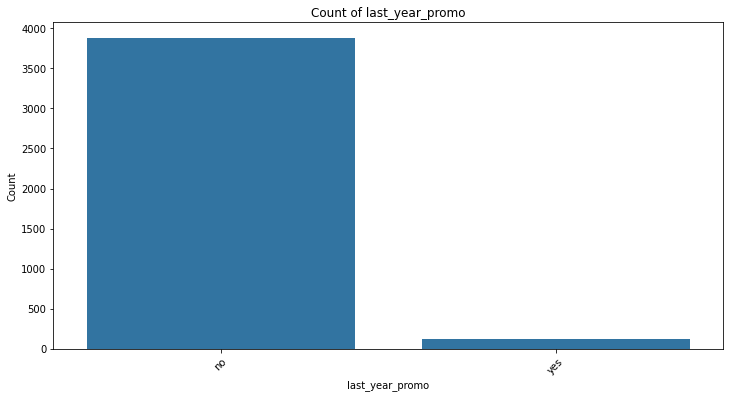

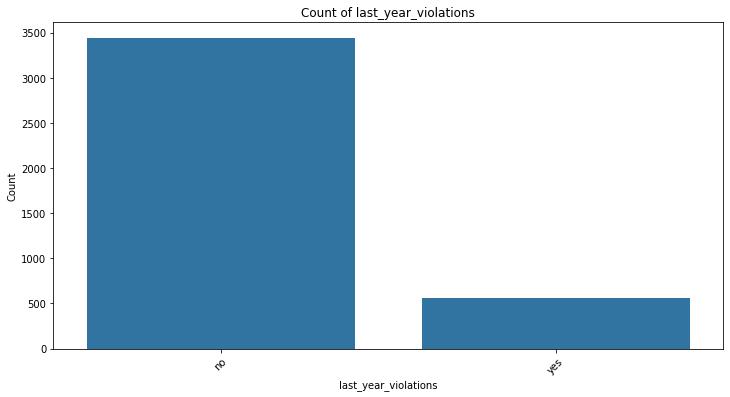

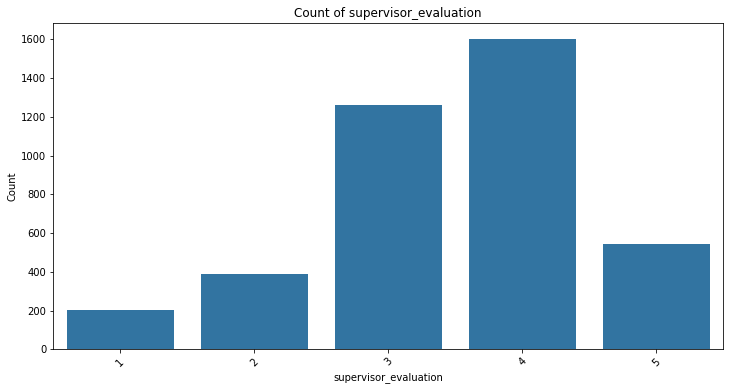

In [49]:
#напишем функцию для построения графиков для категориальных данных датасета train_job
for column in categorical_disc_columns:
    plt.figure(figsize=(12, 6))
    sns.countplot(x=column, data=train_job)
    plt.title(f'Count of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

Согласно результатам, большинство работников представлено из отдела продаж (ок 1500), далее идут отделы технологии (900), закупок (600) и маркетинга (550) и отдела кадров (ок 430). В датасете train_job большинство сотрудников уровня junior (1800), затем идут middle(1750) и senior (их всего ок 300). Большинство сотрудников оценивает свою рабочую загрузку как medium (2000), далее идут low (1250) и high (750). Большинство сотрудников, представленных в датасете работает в компании 1-2 года. У подавляющего большинства сотрудников повышения в последний год не наблюдалось. Также подавляющее большинство трудовой договор не нарушали (3300 против 500 тех, кто нарушал). Качество работы большинства сотрудников оценивается на 4 или 3. 

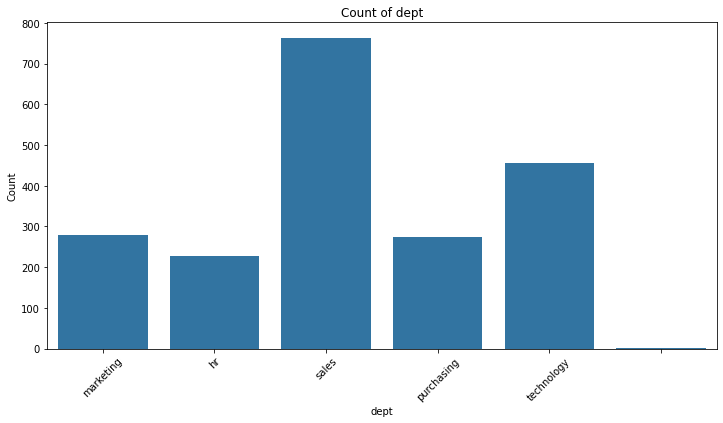

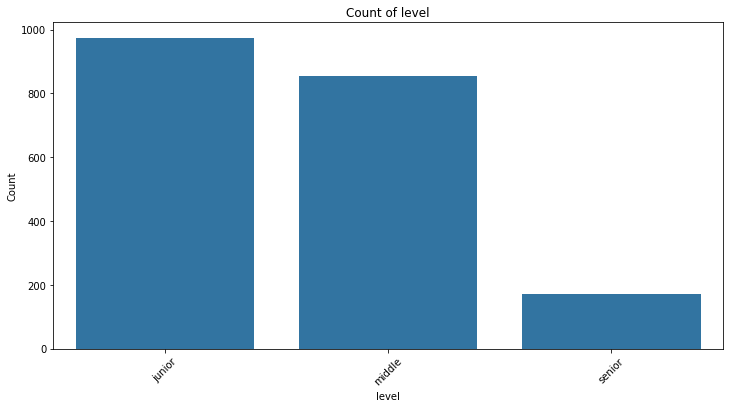

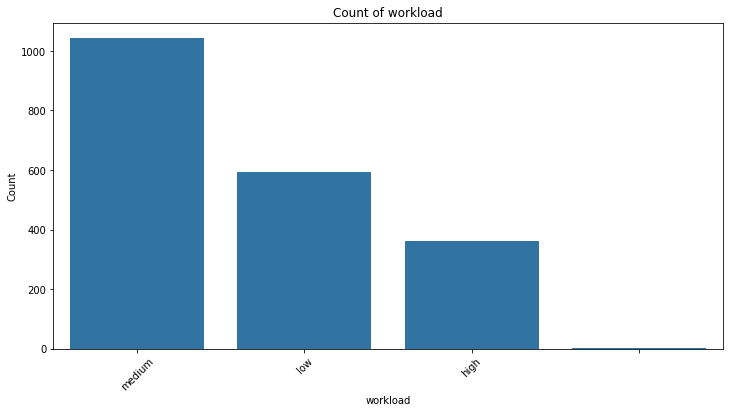

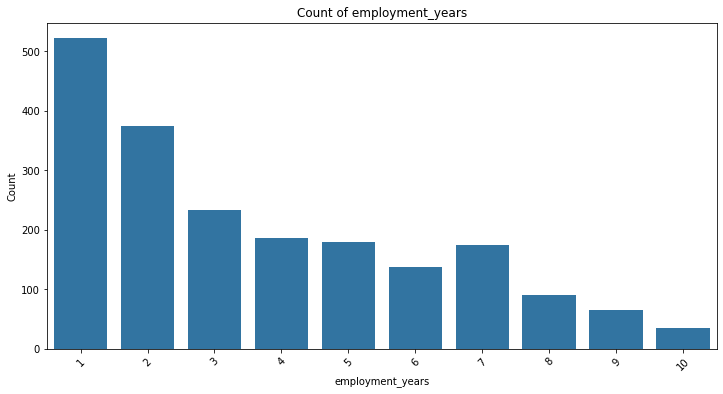

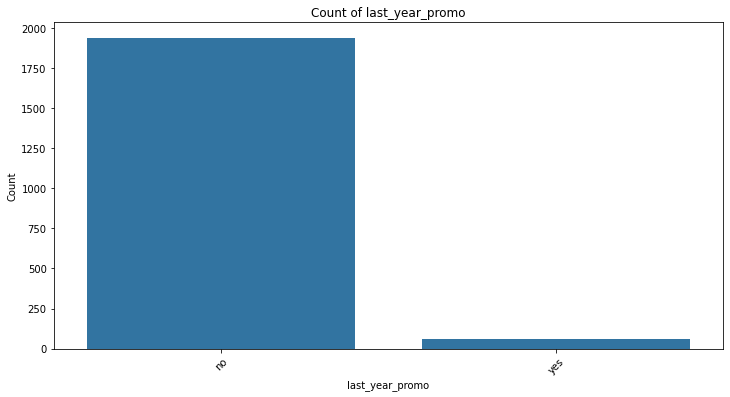

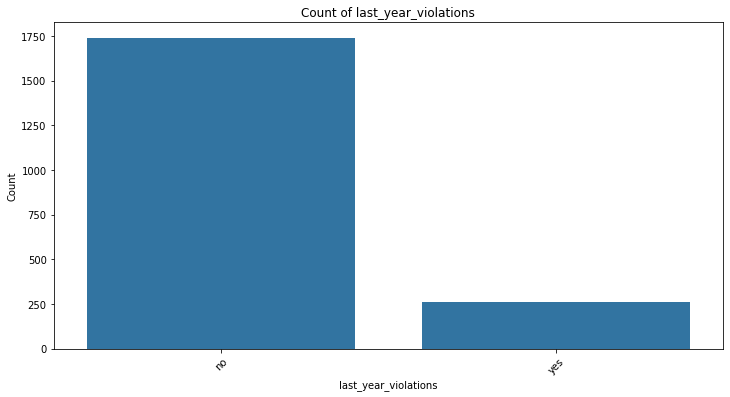

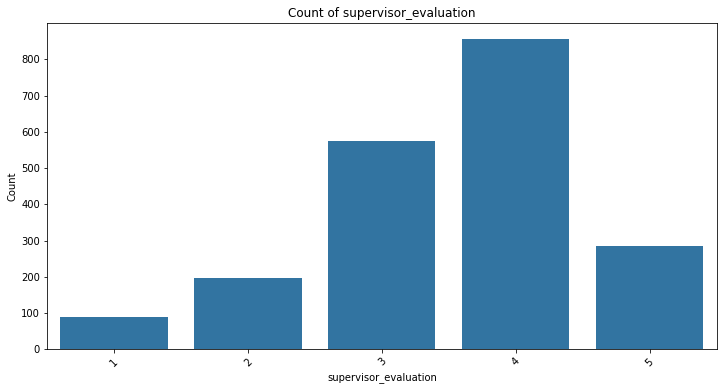

In [50]:
#напишем функцию для построения графиков для категориальных данных датасета test_job
for column in categorical_disc_columns:
    plt.figure(figsize=(12, 6))
    sns.countplot(x=column, data=test_job)
    plt.title(f'Count of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

Согласно результатам, большинство работников представлено из отдела продаж (ок 750), далее идут отделы технологии (450), закупок (270) и маркетинга (270) и отдела кадров (ок 200). В датасете test_job большинство сотрудников уровня junior (980), затем идут middle(850) и senior (их всего ок 300). Большинство сотрудников оценивает свою рабочую загрузку как medium (1000), далее идут low (580) и high (380). Большинство сотрудников, представленных в датасете работает в компании 1-2 года. У подавляющего большинства сотрудников повышения в последний год не наблюдалось. Также подавляющее большинство трудовой договор не нарушали (1700 против 250 тех, кто нарушал). Качество работы большинства сотрудников оценивается на 4 или 3. Таким образом, характер распределения по категориям такой же, как и в train_job

У нас имеется значительный дисбаланс в некоторых категориях, например, подавляющее большинство сотрудников не нарушали трудовой договор. Для устранения дисбаланса можно использовать методы ресемплинга, например, с использованием метода SMOTE. Сделаем это на этапе паплайна

## Корреляционный анализ

Теперь рассмотрим взаимосвязи между признаками в датасете train_job

In [51]:
data_train = train_job.drop(['id'], axis=1)

In [52]:
data_train.head(2)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,sales,junior,medium,2,no,no,1,24000,0.58
1,hr,junior,high,2,no,no,5,38400,0.76


In [53]:
#список непрерывных признаков
interval_cols = ['salary', 'job_satisfaction_rate']

In [54]:
# построим матрицу корреляций в том числе и для категориальных признаков с помощью phik_matrix() 
data_train.phik_matrix(interval_cols=interval_cols) 

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
dept,1.000000,0.000000,0.016509,0.037853,0.000000,0.000000,0.105495,0.282265,0.082086
level,0.000000,1.000000,0.419114,0.682773,0.101613,0.000000,0.000000,0.717630,0.080620
workload,0.016509,0.419114,1.000000,0.181941,0.058663,0.000000,0.037023,0.788820,0.056128
employment_years,0.037853,0.682773,0.181941,1.000000,0.183579,0.056808,0.000000,0.483419,0.325603
last_year_promo,0.000000,0.101613,0.058663,0.183579,1.000000,0.000000,0.013681,0.215025,0.190803
last_year_violations,0.000000,0.000000,0.000000,0.056808,0.000000,1.000000,0.182042,0.010078,0.560348
supervisor_evaluation,0.105495,0.000000,0.037023,0.000000,0.013681,0.182042,1.000000,0.000000,0.764364
salary,0.282265,0.717630,0.788820,0.483419,0.215025,0.010078,0.000000,1.000000,0.165830
job_satisfaction_rate,0.082086,0.080620,0.056128,0.325603,0.190803,0.560348,0.764364,0.165830,1.000000


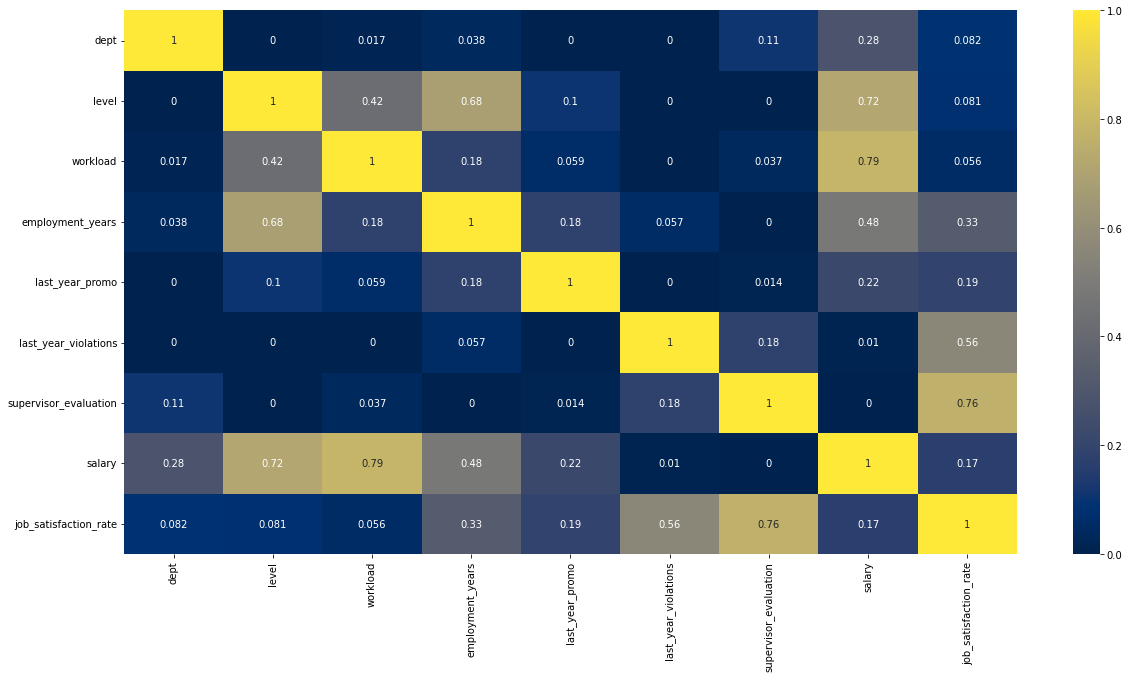

In [55]:
#визуализируем полученную матрицу
plt.figure(figsize=(20,10))
sns.heatmap(data_train.phik_matrix(interval_cols=interval_cols), annot=True, cmap='cividis');

Исходя из полученной матрицы корреляции Phik, можно отметить следующее: job_satisfaction_rate больше зависит от оценки качества работы сотрудника, далее от нарущений трудового договора, заработной платы и повышения в последний год. 
Также можно заметить несколько сильных корреляций: salary и workload: Корреляция 0.79 —  высокая корреляция, что может свидетельствовать о том, что эти признаки несут схожую информацию. Что может быть логичным чем выше загрузка, тем выше заработная плата.
salary и level: Корреляция 0.72 — также высокая корреляция, что может указывать на зависимость этих признаков. Также логичная корреляция, что уровень заработной платы зависит от уровня самого работника.

Проведем аналогичный анализ для test выборки

In [56]:
data_test = test_job.drop(['id'], axis=1)

In [57]:
# построим матрицу корреляций для data_test в том числе и для категориальных признаков с помощью phik_matrix() 
data_test.phik_matrix(interval_cols=interval_cols) 

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
dept,1.000000,0.000000,0.032472,0.000000,0.000000,0.000000,0.020219,0.238060,0.034159
level,0.000000,1.000000,0.196737,0.689666,0.118258,0.017527,0.000000,0.748998,0.095706
workload,0.032472,0.196737,1.000000,0.167397,0.082891,0.000000,0.008174,0.739462,0.000000
employment_years,0.000000,0.689666,0.167397,1.000000,0.173637,0.066371,0.000000,0.494701,0.313525
last_year_promo,0.000000,0.118258,0.082891,0.173637,1.000000,0.000000,0.011704,0.193727,0.337002
last_year_violations,0.000000,0.017527,0.000000,0.066371,0.000000,1.000000,0.189719,0.000000,0.554811
supervisor_evaluation,0.020219,0.000000,0.008174,0.000000,0.011704,0.189719,1.000000,0.114588,0.769857
salary,0.238060,0.748998,0.739462,0.494701,0.193727,0.000000,0.114588,1.000000,0.171903
job_satisfaction_rate,0.034159,0.095706,0.000000,0.313525,0.337002,0.554811,0.769857,0.171903,1.000000


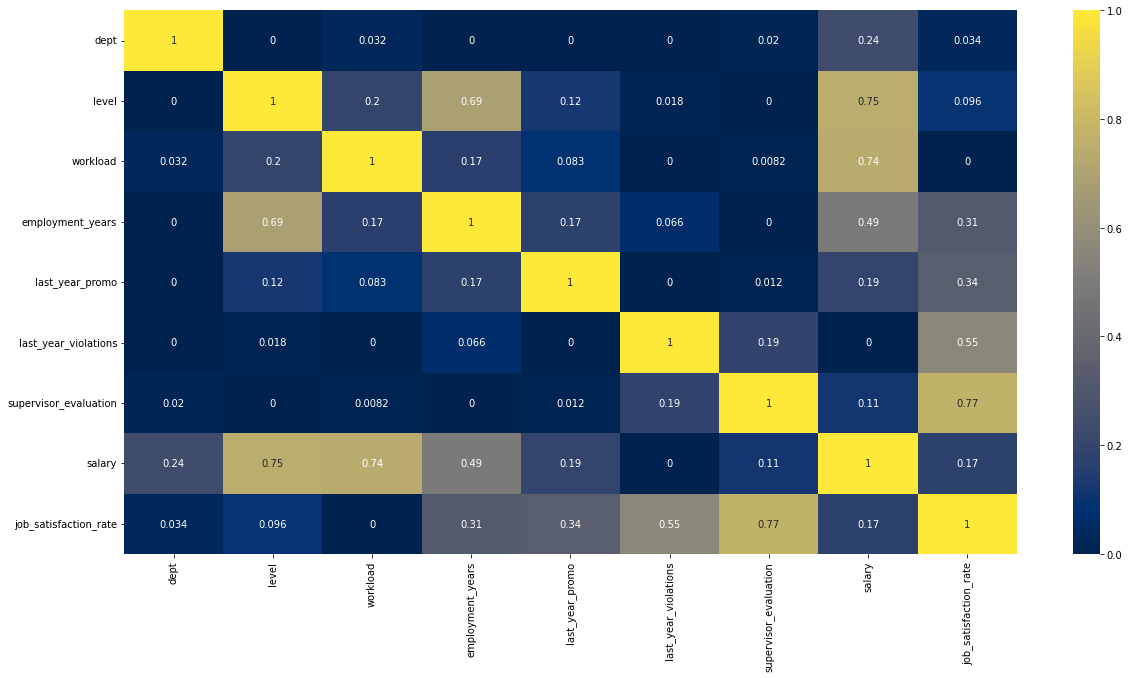

In [58]:
#визуализируем полученную матрицу
plt.figure(figsize=(20,10))
sns.heatmap(data_test.phik_matrix(interval_cols=interval_cols), annot=True, cmap='cividis');

Исходя из полученной матрицы корреляции Phik, можно отметить схожую с data_train ситуацию (но с небольшими изменениями): job_satisfaction_rate больше зависит от оценки качества работы сотрудника, далее от нарущений трудового договора, повышения в последний год, трудового стажа и заработной платы. Также можно заметить несколько сильных корреляций: salary и workload: Корреляция 0.74 — высокая корреляция, что может свидетельствовать о том, что эти признаки несут схожую информацию. Что может быть логичным чем выше загрузка, тем выше заработная плата. salary и level: Корреляция 0.75 — также высокая корреляция, что может указывать на зависимость этих признаков. Также логичная корреляция, что уровень заработной платы зависит от уровня самого работника.

Пока не будем удалять данные признаки для избежания мультиколлинеарности, можем попробовать использовать регуляризацию, к примеру L1-регуляризацию, чтобы помочь снизить влияние мультиколлинеарных признаков.

Расчёт VIF помогает определить, насколько степень корреляции между признаками может повлиять на устойчивость модели. Значения VIF выше 10 (или иногда 5) указывают на значительную мультиколлинеарность.

In [59]:
quantitative_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

In [60]:
# удалим нечисловые столбцы
numeric_data = data_train[quantitative_columns].copy()

In [61]:
numeric_data.head(2)

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
0,2,1,24000,0.58
1,2,5,38400,0.76


In [62]:
# добавим константы для расчета VIF
X = add_constant(numeric_data)

In [63]:
#вычислим VIF
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

In [64]:
vif_data

,feature,VIF
0,const,18.543427
1,employment_years,1.358397
2,supervisor_evaluation,2.001941
3,salary,1.275237
4,job_satisfaction_rate,2.093636


Тут проблем с числовыми данными нет, значения VIF для всех признаков находятся в допустимом пределе.

Далее проведем аналогичный анализ для test выборки

In [65]:
# удалим нечисловые столбцы
numeric_data2 = data_test[quantitative_columns].copy()

In [66]:
numeric_data2.head(2)

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
0,2,5,28800,0.79
1,1,4,30000,0.72


In [67]:
# добавим константы для расчета VIF
X = add_constant(numeric_data2)

In [68]:
#вычислим VIF
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

In [69]:
vif_data

,feature,VIF
0,const,17.737435
1,employment_years,1.348034
2,supervisor_evaluation,2.071594
3,salary,1.286756
4,job_satisfaction_rate,2.175737


Тут также проблем с числовыми данными нет, значения VIF для всех признаков находятся в допустимом пределе.

In [70]:
#проверим наличие дубликатов после удаления id для train выборки
data_train.duplicated().sum()

245

Найдено 245 дубликатов, удалим их

In [71]:
data_train = data_train.drop_duplicates().reset_index(drop = True)

In [72]:
#проверим наличие дубликатов после удаления id для train выборки
data_train.duplicated().sum()

0

Дубликаты в датасете data_train удалены

## Использование паплайна

In [73]:
RANDOM_STATE = 42
#определим наши обучающую и тестовую выборки
X_train = data_train.drop('job_satisfaction_rate', axis=1)

In [74]:
y_train = data_train['job_satisfaction_rate']
X_test = data_test.drop(['job_satisfaction_rate'], axis=1)
y_test = data_test['job_satisfaction_rate']
X_train.shape, X_test.shape

((3755, 8), (2000, 8))

Далее обозначим, какие данные требуют масштабирования, а какие — кодирования.

При кодировании, для признаков у которых есть определенный порядок/иерархия мы используем OrdinalEncoder. В нашем датасете это будет: level, workload. Признаки dept, last_year_promo, last_year_violations мы закодируем с помощью OneHotEncoder

In [75]:
# создаём списки с названиями признаков
ohe_columns = ['dept','last_year_promo', 'last_year_violations']  
ord_columns = ['level', 'workload']  

In [76]:
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

При кодировании неизвестных категорий могут возникнуть пропуски. Обработать их поможет инструмент SimpleImputer, который заменит недостающие значения в данном случае на моду.

In [77]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

In [78]:
# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'], 
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [79]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough', force_int_remainder_cols=False
)

In [80]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])
param_grid= [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(8, 15),
        'models__max_features': range(7, 15),
        'models__min_samples_leaf': range(1, 5),
        'models__min_samples_split': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },

    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'models__fit_intercept': [True, False],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }   
]

Теперь задача стоит определиться с метрикой, подходящей для нашей задачи. В данном случае мы будем использовать метрику SMAPE (англ. symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение»). 

Сначала напишем данную функцию

In [81]:
#напишем функцию для расчета SMAPE
def smape(y_test, y_pred):
    smape_value = 100*np.sum((2 * np.abs(y_test - y_pred) / (np.abs(y_test) + np.abs(y_pred))))/len(y_test)
    return np.abs(smape_value)
smape_scorer = make_scorer(smape, greater_is_better=False)

In [82]:
# Инициализация GridSearchCV
grid_search = GridSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring= smape_scorer,
    n_jobs=-1
)

# Обучение модели
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['dept',
                                                                          'last_year_promo',
                                                                          'last_year...
                          'models__min_samples_leaf': range(1, 5),
                          'models__min_samples_split': range(2, 10),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [LinearRegression()],
                          'models__fit_intercept': [True, False],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring=make_scorer(smape, greater_is_better=False, response_method='predict'))

In [83]:
print('Метрика SMAPE для лучшей модели:\n', -grid_search.best_score_)
print('\nЛучшая модель и её параметры:\n\n', grid_search.best_estimator_) 

Метрика SMAPE для лучшей модели:
 14.850659706902183

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                         

Таким образом, лучшей моделью оказалась модель DecisionTreeRegressor со следующими параметрами: max_depth=13, max_features=8,
                                       min_samples_split=8, random_state=42

In [84]:
# проверим работу модели на тестовой выборке
# рассчитаем прогноз на тестовых данных
y_test_pred = grid_search.predict(X_test)
print(f'Метрика smape_scorer на тестовой выборке: {smape(y_test, y_test_pred)}')

Метрика smape_scorer на тестовой выборке: 13.608538914514208


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Метрика smape_scorer на тестовой выборке: 13.60. Таким образом, критерий успешности модели 'SMAPE ≤15 на тестовой выборке' выполнен

In [85]:
# Метрики для оценки
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)

# Оценка с помощью кросс-валидации на 5 фолдах
cv_scores_mae = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5, scoring=mae_scorer, n_jobs=-1)
cv_scores_r2 = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5, scoring=r2_scorer, n_jobs=-1)

print(f'MAE: {np.abs(cv_scores_mae.mean()):.4f} ± {cv_scores_mae.std():.4f}')
print(f'R^2: {cv_scores_r2.mean():.4f} ± {cv_scores_r2.std():.4f}')

MAE: 0.0601 ± 0.0025
R^2: 0.8766 ± 0.0073


MAE (средняя абсолютная ошибка) равна 0.0601, что указывает на то, что среднее абсолютное отклонение предсказанных значений от истинных составляет примерно 0.0601. Стандартное отклонение MAE равно 0.0025, что указывает на относительно небольшие колебания этой метрики между фолдами, свидетельствуя о стабильности модели.

Коэффициент детерминации (R²) составляет 0.87, что означает, что модель объясняет примерно 87% дисперсии данных. Это хороший результат, указывающий на высокую точность модели в объяснении вариаций целевой переменной. Стандартное отклонение R² равно 0.0073, что подтверждает стабильность этой метрики при кросс-валидации.

Таким образом, модель демонстрирует стабильные результаты на разных фолдах, что подтверждается низкими стандартными отклонениями для всех метрик. MAE и R² показывают приемлемые ошибки предсказаний и высокую точность модели в объяснении вариаций целевой переменной.

Далее сравним нашу лучшую модель с константной моделью

In [86]:
# Инициализация DummyRegressor со стратегией 'mean'
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(X_train, y_train)

# Предсказания константной модели на тестовых данных
y_dummy_pred = dummy_model.predict(X_test)

# Оценка качества константной модели
dummy_smape = smape(y_test, y_dummy_pred)

print(f'Метрика SMAPE для константной модели: {dummy_smape}')

Метрика SMAPE для константной модели: 38.26225790202237


Наша лучшая модель значительно превосходит константную модель, что подтверждает, что все усилия по созданию новых признаков, тюнингу и кросс-валидации оправданы. Это также подтверждает, что наша модель вносит существенный вклад в улучшение качества предсказаний по сравнению с простым подходом.

Далее проведем анализ остатков.

In [87]:
# Предсказанные значения на тестовой выборке
y_test_pred = grid_search.best_estimator_.predict(X_test)
residuals = y_test - y_test_pred

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


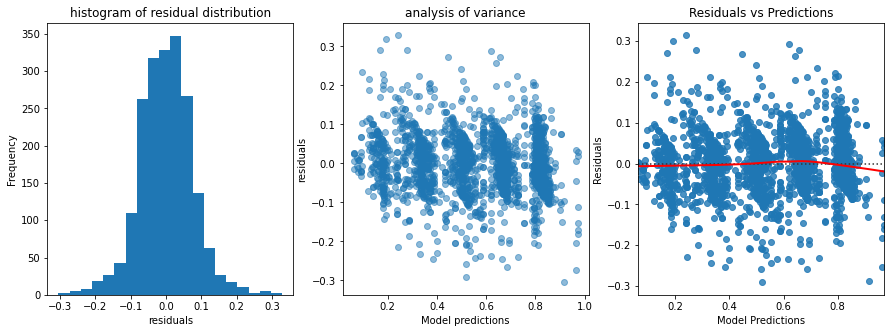

In [88]:
#Построим графики по количественным признакам - гистограмму частотности
#распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows = 1, ncols= 3, figsize = (15, 5))

axes[0].hist(residuals, bins = 20)
axes[0].set_title('histogram of residual distribution')
axes[0].set_xlabel('residuals')
axes[0].set_ylabel('Frequency')

axes[1].scatter(y_test_pred, residuals, alpha = 0.5)
axes[1].set_xlabel('Model predictions')
axes[1].set_ylabel('residuals')
axes[1].set_title('analysis of variance')

# sns.residplot для оценки распределения остатков и их гомоскедастичности
sns.residplot(x=y_test_pred, y=residuals, lowess=True, ax=axes[2], line_kws={'color': 'red', 'lw': 2})
axes[2].set_title('Residuals vs Predictions')
axes[2].set_xlabel('Model Predictions')
axes[2].set_ylabel('Residuals')

plt.show()

Остатки модели не только показывают разницу между предсказанным и истинным значениями. Они также отражают закономерности, которые позволяют судить о качестве модели. Анализ остатков проверяет не решения модели, а то, насколько хорошо она замечает взаимосвязи между признаками. Если она не справляется с этим, то уже не важно, близки ли её предсказания к исходным значениям. Модель будет работать нестабильно.

Если посмотрим на график распределения остатков (график слева), то он показывает симметричное распределение, но на графике есть небольшие выбросы, это может свидетельствовать о том, что модель в целом хорошо справляется с предсказаниями, но есть отдельные наблюдения, которые модель не может объяснить должным образом. Это довольно обычное явление, особенно если данные содержат шум или аномалии.Наличие небольших выбросов не обязательно является проблемой, особенно если они редки. 
Если посмотрим на диаграмму рассеяния (2 графика справа) остатков в зависимости от прогнозных значений модели, то отметим, что линия, полученная с помощью lowess, практически прямая, но с небольшим искривлением, это указывает на то, что остатки модели в целом распределены нормально, но возможны незначительные отклонения в зависимости от предсказанных значений. Небольшое искривление линии может свидетельствовать о возможных нелинейных отношениях, которые модель не полностью улавливает. В таком случае, модель может слегка недооценивать или переоценивать значения в определенных диапазонах предсказаний.

## Анализ важности признаков

In [89]:
best_pipeline = grid_search.best_estimator_
best_model = best_pipeline.named_steps['models']

In [90]:
preprocessor = best_pipeline.named_steps['preprocessor']

In [91]:
#преобразуем X_test_transformed
X_test_transformed = preprocessor.transform(X_test)
X_train_transformed = preprocessor.transform(X_train)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [92]:
# Получение важностей признаков
feature_importances = best_model.feature_importances_

# Создание DataFrame для важностей признаков
feature_names = np.array(preprocessor.get_feature_names_out())
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Score': feature_importances
}).sort_values(by='Score', ascending=False)

# Отображение важностей признаков
print(feature_importances_df)

                          Feature     Score
9      num__supervisor_evaluation  0.670750
10                    num__salary  0.084694
8           num__employment_years  0.080651
5   ohe__last_year_violations_yes  0.054363
6                      ord__level  0.040100
7                   ord__workload  0.020127
3            ohe__dept_technology  0.014903
4        ohe__last_year_promo_yes  0.012624
0             ohe__dept_marketing  0.009929
2                 ohe__dept_sales  0.008213
1            ohe__dept_purchasing  0.003646


Признак num__supervisor_evaluation (0.710) имеет наивысший вес, что указывает на его высокую важность для модели. Рейтинг производительности от супервизора значительно влияет на предсказания модели. Признак "Количество лет работы" имеет относительно низкую, но все же значимую важность. Это может указывать на то, что опыт работы имеет некоторое влияние на целевую переменную, но не настолько выраженное, как оценка супервизора. Значение "Зарплата" также имеет умеренную важность. Хотя зарплата оказывает влияние на результат, она не так критична, как оценка супервизора. Признак "Нарушения в прошлом году (да)" имеет умеренное значение, что указывает на его вклад в модель. Нарушения могут оказывать влияние на предсказания, но не являются основным фактором. "Уровень" сотрудника имеет небольшое, но заметное влияние на модель. Уровень должности или позиции может иметь некоторое значение, но его влияние относительно невелико. Признак "Рабочая нагрузка" имеет низкий вес. Это указывает на то, что рабочая нагрузка в минимальной степени влияет на предсказания модели. "Продвижение в прошлом году (да)" также имеет небольшой вес. Хотя продвижение может иметь значение, его влияние на целевую переменную относительно невелико.
Признак "департамент" имеет минимальное влияние на результат модели.

In [93]:
background_data = shap.kmeans(X_test_transformed, 100)

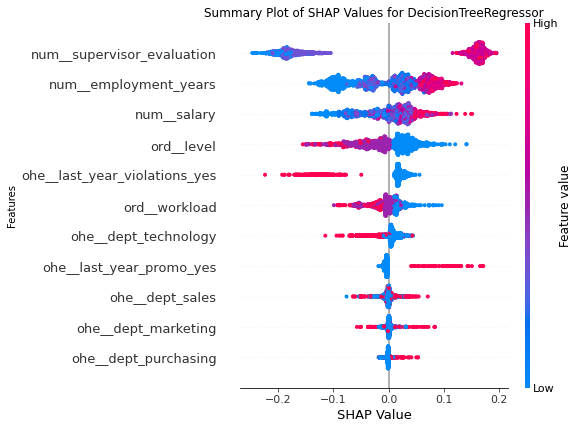

In [94]:
# Инициализация TreeExplainer для DecisionTreeRegressor
explainer = shap.TreeExplainer(best_model)

# Получение SHAP значений
shap_values = explainer.shap_values(X_test_transformed)

# Создаем фигуру и оси вручную
fig, ax = plt.subplots(figsize=(12, 8))

# Выполним визуализацию SHAP
# В случае с регрессией SHAP значение всегда одно
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names, show=False)

# Получаем текущие оси
current_ax = plt.gca()

# Добавляем подписи и заголовок
current_ax.set_xlabel('SHAP Value')
current_ax.set_ylabel('Features')
current_ax.set_title('Summary Plot of SHAP Values for DecisionTreeRegressor')

# Показываем график
plt.show()

Согласно графику, высокие значения признака 'оценка качества работы сотрудника, которую дал руководитель' оказывают большое влияние на  уровень удовлетворённости сотрудника работой в компании, так высокие значения данной оценки повышают вероятность удовлетворенности сотрудника и наоборот.еньше влияния, но такая же ситуация со сроком службы сотрудника. И наоборот, если у клиентов мало просмотров страниц, то активность будет снижаться. 
Обратная тенденция наблюдается для признаков: last_year_violation_yes/нарушал ли сотрудник трудовой договор за последний год, level/уровень занимаемой должности, workload/уровень загруженности сотрудника. Для данных признаков высокие значения снижают вероятность удовлетворенности сотрудника.
Мало значимыми признаком/признаками является департамент, где работает сотрудник

Таким образом, Модель DecisionTreeRegressor с подобранными гиперпараметрами (max_depth=13, max_features=8, min_samples_split=8, random_state=42) показала хорошие результаты на тестовой выборке и кросс-валидации, что подтверждает её способность предсказывать уровень удовлетворённости сотрудников на основе доступных данных.
Важные признаки, такие как оценка супервизора и количество лет работы, оказались ключевыми для определения уровня удовлетворённости сотрудников.
Модель продемонстрировала свою эффективность по сравнению с простой константной моделью, что свидетельствует о качественном подходе к построению и оптимизации модели.

# ЗАДАЧА 2

## Загрузка и предварительный анализ данных 

In [95]:
# загрузим данные датасета train_quit
train_quit = pd.read_csv('/datasets/train_quit.csv')

In [96]:
#выведем на экран первые 5 строк полученного датасета
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [97]:
#посмотрим на общую информацию датасета
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [98]:
#посмотрим на количество пропущенных значений 
train_quit.isna().sum()

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

Таким образом датасет train_quit представляет собой таблицу с 4000 записями и 10 столбцами. 4 столбца имеют числовой тип данных (int64), остальные 6 - строковый тип данных (object). Тип данных столбцов соответствует информации, представленной в них. Также, можно отметить, что в датасете отсутствуют пропуски.

In [99]:
# загрузим данные датасета test_features
test_features = pd.read_csv('/datasets/test_features.csv')

In [100]:
#выведем первые 5 строк датафрейма test_features
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [101]:
#посмотрим на общую информацию полученного датасета test_features
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [102]:
# посмотрим на количество пропущенных значений в каждом из столбцов
test_features.isna().sum()

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

датасет test_features представляет собой таблицу с 2000 записями и 9 столбцами. 4 столбца имеют числовой тип данных (int64), остальные 5 - строковый тип данных (object). Тип данных столбцов соответствует информации, представленной в них. Можно заметить 2 пропущенных значения в столбце 'dept' и 1 значение в столбце 'level', которые можем удалить или предобработать на этапе подготовки данных в паплайне

In [103]:
# загрузим данные датасета test_target_quit
test_target_quit = pd.read_csv('/datasets/test_target_quit.csv')

In [104]:
#выведем первые 5 строк полученного датасета test_target_quit
test_target_quit.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [105]:
# посмотрим на общую информацию датасета test_target_quit
test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [106]:
# проверим наличие пропущенных значений в датасете test_target_quit
test_target_quit.isna().sum()

id      0
quit    0
dtype: int64

датасетtest_target_quit представляет собой таблицу с 2000 записями и 2 столбцами. 1 столбец id имеет числовой тип данных (int64), другой - строковый тип данных (object). Тип данных столбцов соответствует информации, представленной в них. Пропущенных данных не обнаружено

In [107]:
#объединим 2 части тестовых данных (для корректного удаления пропусков)
test_quit = pd.merge(test_features, test_target_quit, on='id', how='inner')

In [108]:
test_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,no
1,686555,hr,junior,medium,1,no,no,4,30000,no
2,467458,sales,middle,low,5,no,no,4,19200,no
3,418655,sales,middle,low,6,no,no,4,19200,no
4,789145,hr,middle,medium,5,no,no,5,40800,no


In [109]:
test_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
 9   quit                   2000 non-null   object
dtypes: int64(4), object(6)
memory usage: 156.4+ KB


In [110]:
# проверим наличие пропущенных значений
test_quit.isna().sum()

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

##  Предобработка данных

### Определение наличия явных и неявных дубликатов

####  Определения наличия явных дубликатов

In [111]:
# проверим наличие явных дубликатов в датафрейме train_quit
train_quit.duplicated().sum()

0

Явных дубликатов не обнаружено

In [112]:
# проверим наличие явных дубликатов в датафрейме test_quit
test_quit.duplicated().sum()

0

Явных дубликатов не обнаружено

#### Определение наличия неявных дубликатов

Теперь проверим неявные дубликаты в датасете train_quit

In [113]:
# Проверим на дубликаты по выбранной комбинации столбцов для train_quit
duplicate_rows3 = train_quit.duplicated(subset=['id', 'dept', 'level', 'workload', 'employment_years'], keep=False)

In [114]:
train_quit[duplicate_rows3]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit


In [115]:
# Проверим на дубликаты по выбранной комбинации столбцов для test_quit
duplicate_rows4 = test_quit.duplicated(subset=['id', 'dept', 'level', 'workload', 'employment_years'], keep=False)

In [116]:
test_quit[duplicate_rows4]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit


Неявных дубликатов не обнаружено

####  Анализ столбцов категориальных данных

In [117]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [118]:
#выведем на экран все уникальные значения столбца 'dept'
train_quit['dept'].unique()

array(['sales', 'purchasing', 'marketing', 'technology', 'hr'],
      dtype=object)

В датасете представлены данные для 5 отделов: 'sales', 'hr', 'technology', 'purchasing', 'marketing'

In [119]:
#выведем на экран все уникальные значения столбца 'level'
train_quit['level'].unique()

array(['middle', 'junior', 'sinior'], dtype=object)

In [120]:
#заменяем 'sinior' на 'senior'
train_quit['level'] = train_quit['level'].replace('sinior', 'senior')

In [121]:
#проверим
train_quit['level'].unique()

array(['middle', 'junior', 'senior'], dtype=object)

В датасете сотрудники поделены на 3 уровня: 'junior', 'middle', 'sinior'

In [122]:
#выведем на экран все уникальные значения столбца 'level'
train_quit['workload'].unique()

array(['high', 'medium', 'low'], dtype=object)

In [123]:
#выведем на экран все уникальные значения столбца 'last_year_promo'
train_quit['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

In [124]:
#выведем на экран все уникальные значения столбца 'last_year_violations'
train_quit['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

Теперь посмотрим на датасет test_quit

In [125]:
#выведем на экран все уникальные значения столбца 'dept'
test_quit['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' '],
      dtype=object)

Похоже у нас есть значение nan и пробел в названии департамента. 

In [126]:
test_quit['dept'].value_counts()

dept
sales         763
technology    455
marketing     279
purchasing    273
hr            227
                1
Name: count, dtype: int64

In [127]:
#выведем на экран все уникальные значения столбца 'level'
test_quit['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

In [128]:
#заменяем 'sinior' на 'senior'
test_quit['level'] = test_quit['level'].replace('sinior', 'senior')

In [129]:
#выведем на экран все уникальные значения столбца 'workload'
test_quit['workload'].unique()

array(['medium', 'low', 'high', ' '], dtype=object)

In [130]:
#выведем на экран все уникальные значения столбца 'last_year_promo'
test_quit['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

In [131]:
#выведем на экран все уникальные значения столбца 'last_year_violations'
test_quit['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

In [132]:
test_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
 9   quit                   2000 non-null   object
dtypes: int64(4), object(6)
memory usage: 156.4+ KB


In [133]:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


## Исследовательский анализ данных

### Статистический анализ признаков

In [134]:
#выведем статистические данные по датасету train_quit
train_quit.describe()

,id,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,552099.283750,3.701500,3.474750,33805.800000
std,260158.031387,2.541852,1.004049,15152.415163
min,100222.000000,1.000000,1.000000,12000.000000
25%,327785.750000,2.000000,3.000000,22800.000000
50%,546673.000000,3.000000,4.000000,30000.000000
75%,781497.750000,6.000000,4.000000,43200.000000
max,999915.000000,10.000000,5.000000,96000.000000


Рассмотрим статистические результаты: 1) Средний стаж работы (employment_years) составляет 5.52 года со стандартным отклонением 2.54 года. Минимальный стаж — 1 год, максимальный — 10 лет. Половина сотрудников имеют стаж работы 5 лет или меньше, а 25% имеют стаж 2 года или меньше. 2) Средняя оценка руководителя составляет 3.47. Стандартное отклонение (1.00) показывает, что оценки руководителей варьируются, но большинство находятся около среднего значения. Половина сотрудников имеют оценку 4 или выше, а 25% — оценку 3 или ниже. 3) Средняя зарплата составляет около 33 806. Стандартное отклонение показывает значительное различие в зарплатах среди сотрудников (15 152). Минимальная зарплата составляет 12 000, максимальная — 96 000. Половина сотрудников получают 30 000 или меньше, а 25% — 22 800 или меньше. 

In [135]:
#выведем статистические данные по датасету test_quit
test_quit.describe()

,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000


Рассмотрим статистические результаты: 1) Средний стаж работы (employment_years) составляет 5.55 года со стандартным отклонением 2.54 года. Минимальный стаж — 1 год, максимальный — 10 лет. Половина сотрудников имеют стаж работы 5 лет или меньше, а 25% имеют стаж 1 год или меньше. 2) Средняя оценка руководителя составляет 3.53. Стандартное отклонение (1.00) показывает, что оценки руководителей варьируются, но большинство находятся около среднего значения. Половина сотрудников имеют оценку 4 или выше, а 25% — оценку 3 или ниже. 3) Средняя зарплата составляет около 34 085. Стандартное отклонение показывает значительное различие в зарплатах среди сотрудников (15 402). Минимальная зарплата составляет 12 000, максимальная — 96 000. Половина сотрудников получают 30 000 или меньше, а 25% — 22 800 или меньше.

### Визуализация и анализ количественных и категориальных признаков

In [136]:
train_quit.head(2)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no


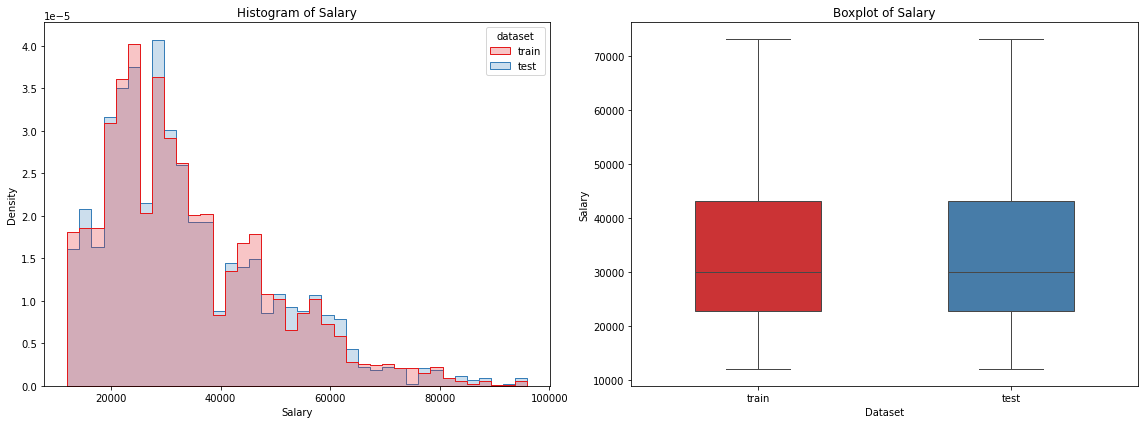

In [137]:
# Создание нового датафрейма для визуализации
combined_df = pd.concat([
    train_quit[['salary']].assign(dataset='train'),
    test_quit[['salary']].assign(dataset='test')
])

# Построение графиков
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Гистограмма
sns.histplot(data=combined_df, x='salary', hue='dataset', element='step', stat='density', common_norm=False, palette='Set1', ax=ax[0])
ax[0].set_title('Histogram of Salary')
ax[0].set_xlabel('Salary')
ax[0].set_ylabel('Density')

# Боксплот
sns.boxplot(data=combined_df, x='dataset', y='salary', hue='dataset', palette='Set1', width=0.5, ax=ax[1], showfliers=False)
ax[1].set_title('Boxplot of Salary')
ax[1].set_xlabel('Dataset')
ax[1].set_ylabel('Salary')

plt.tight_layout()
plt.show()

Посмотрим, что можно сказать о характере распределения данных датасета train_quit и test_quit. Данные по ежемесячной зарплате сотрудников варьируются от 12000 до 96000. Можно отметить отклонение от симметрии в данных, распределение скошено влево с пиком в точке 30000. Характер распределения у test и train идентичен.

In [138]:
#напишем функцию для построения гистограммы для каждого категориального признака и дескретных значений
#сначала укажем, какие признаки у нас относятся к категориальным и дискретным значениям
categorical_disc_columns = ['dept','level', 'workload', 'employment_years', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation', 'quit']

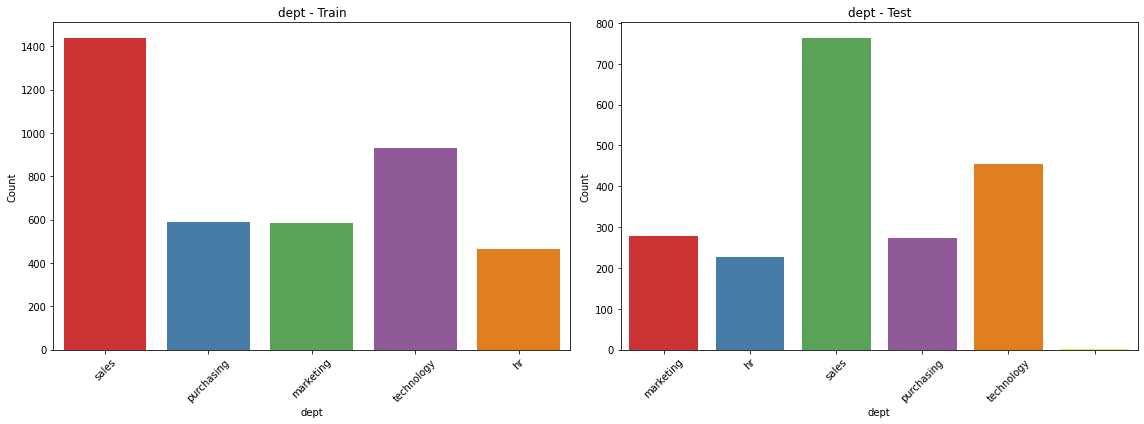

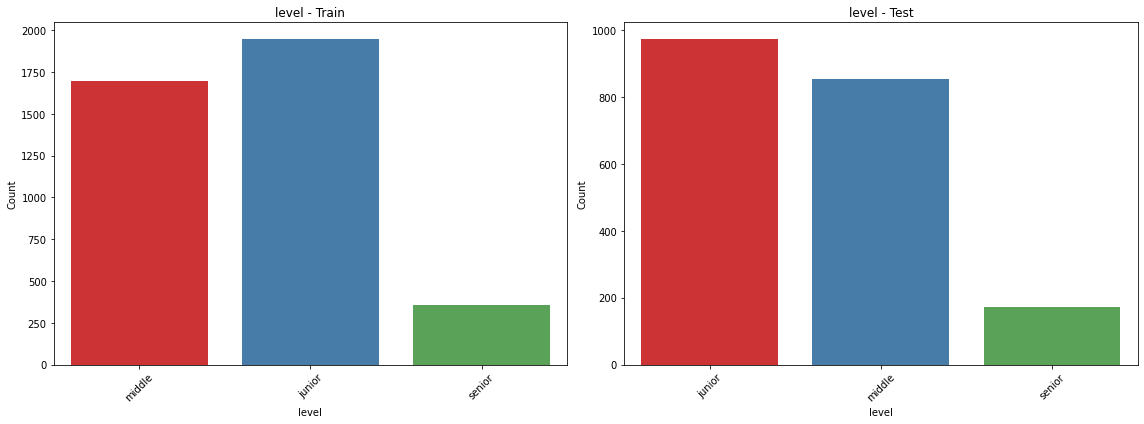

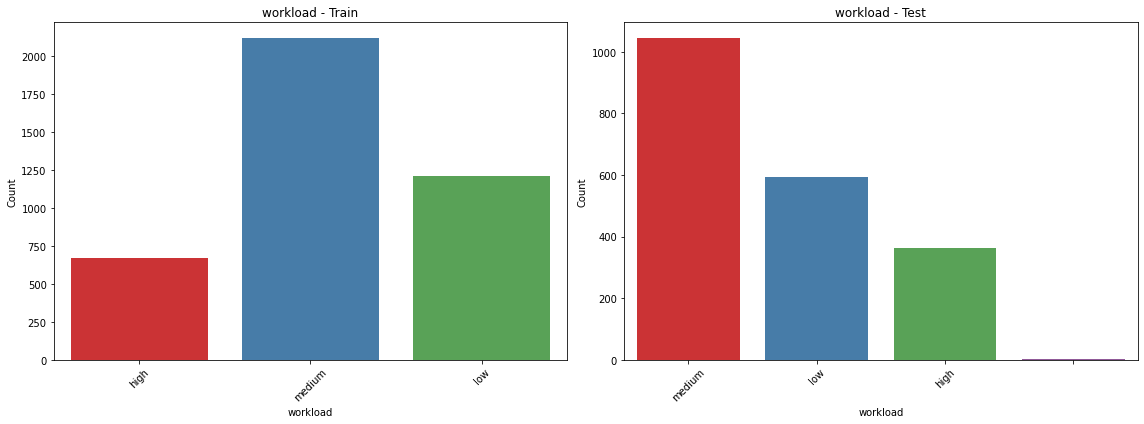

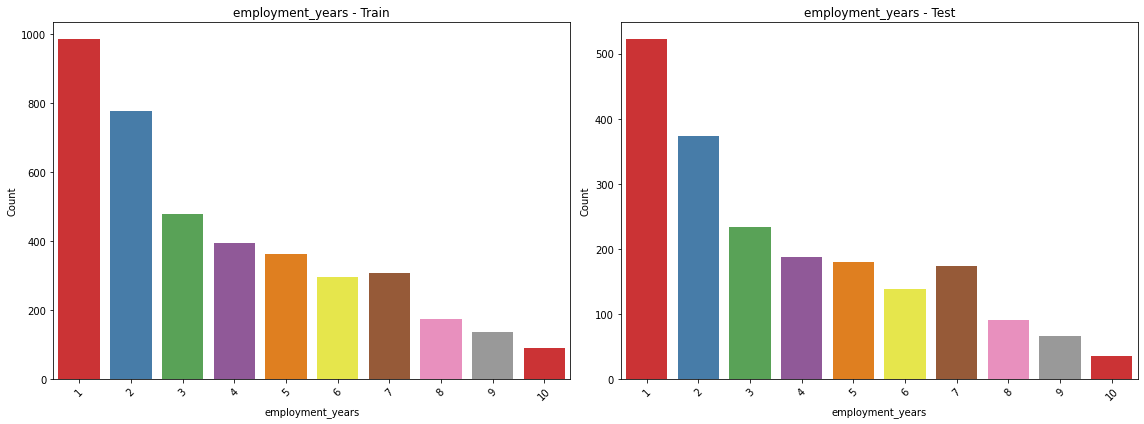

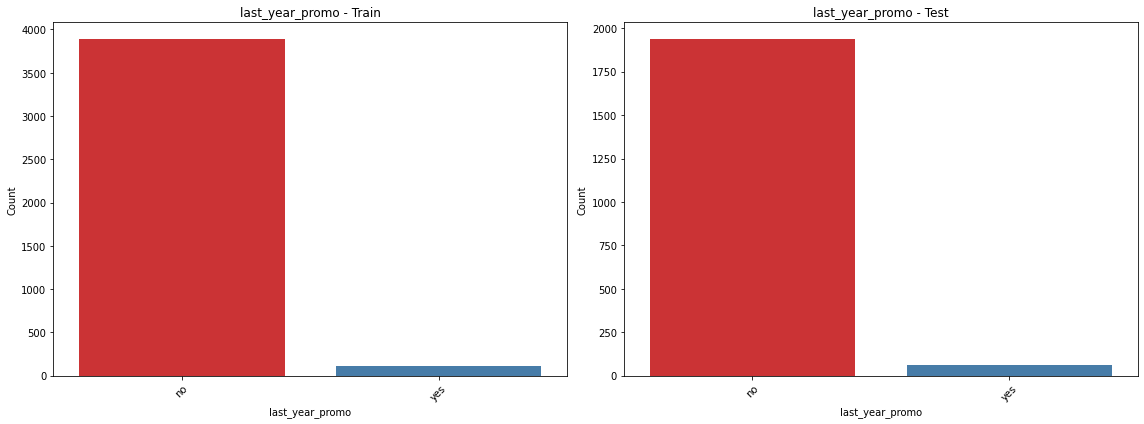

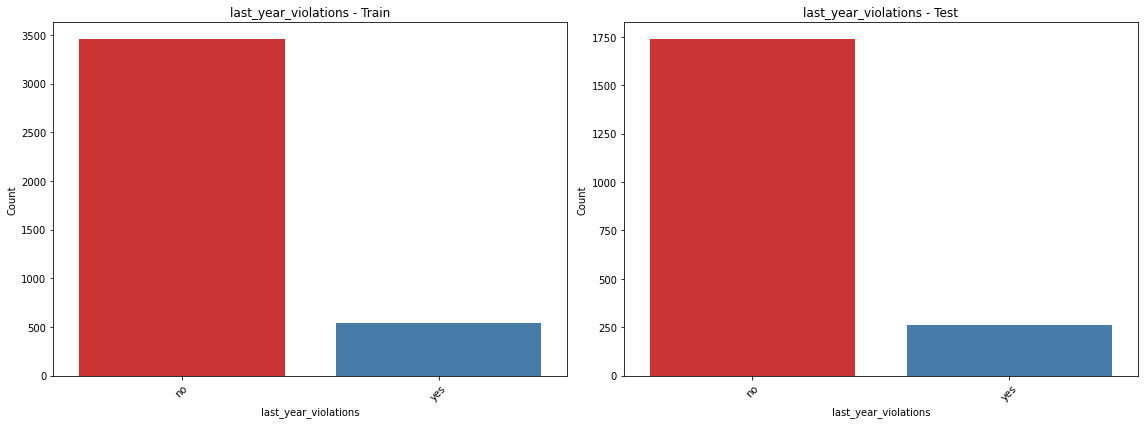

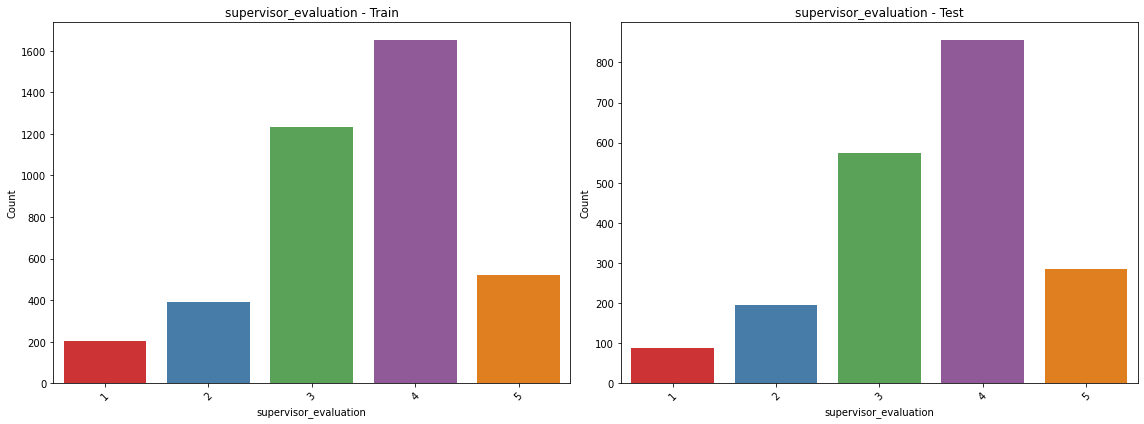

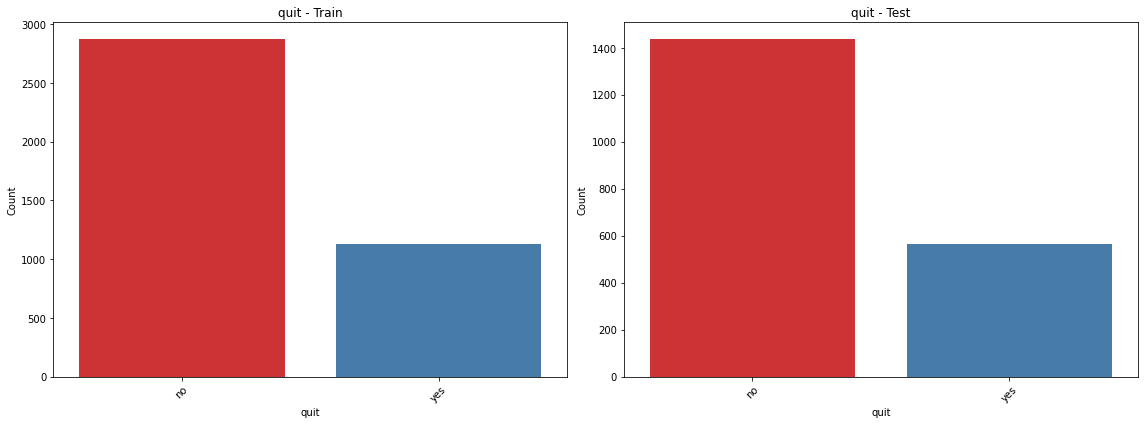

In [139]:
# Построение графиков
for column in categorical_disc_columns:
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    
    # График для train_quit
    sns.countplot(x=column, data=train_quit, ax=ax[0], hue=column, palette='Set1', legend=False)
    ax[0].set_title(f'{column} - Train')
    ax[0].set_xlabel(column)
    ax[0].set_ylabel('Count')
    ax[0].tick_params(axis='x', rotation=45)
    
    # График для test_quit
    sns.countplot(x=column, data=test_quit, ax=ax[1], hue=column, palette='Set1', legend=False)
    ax[1].set_title(f'{column} - Test')
    ax[1].set_xlabel(column)
    ax[1].set_ylabel('Count')
    ax[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

Согласно результатам для train_quit/test_quit, большинство работников представлено из отдела продаж (ок 1400/750), далее идут отделы технологии (900/ 450), закупок (600/250) и маркетинга (600/280) и отдела кадров (ок 430/200). В датасетах большинство сотрудников уровня junior (2000/980), затем идут middle(1700/820) и senior (их всего ок 300/200). Большинство сотрудников оценивает свою рабочую загрузку как medium (2000/1100), далее идут low (1250/600) и high (600/350). Большинство сотрудников, представленных в датасете работает в компании 1-2 года. У подавляющего большинства сотрудников повышения в последний год не наблюдалось. Также подавляющее большинство трудовой договор не нарушали (3300/1700 против 500/250 тех, кто нарушал). Качество работы большинства сотрудников оценивается на 4 или 3. Больщинство сотрудников (2700/1128) не уволилось против (1100/550).

### Портрет уволившегося сотрудника

In [140]:
#получим выборку уволившихся сотрудников
left_employees = train_quit[train_quit['quit'] =='yes']

In [141]:
#получим выборку оставшихся сотрудников
stayed_employees = train_quit[train_quit['quit'] =='no']

In [142]:
left_employees.shape

(1128, 10)

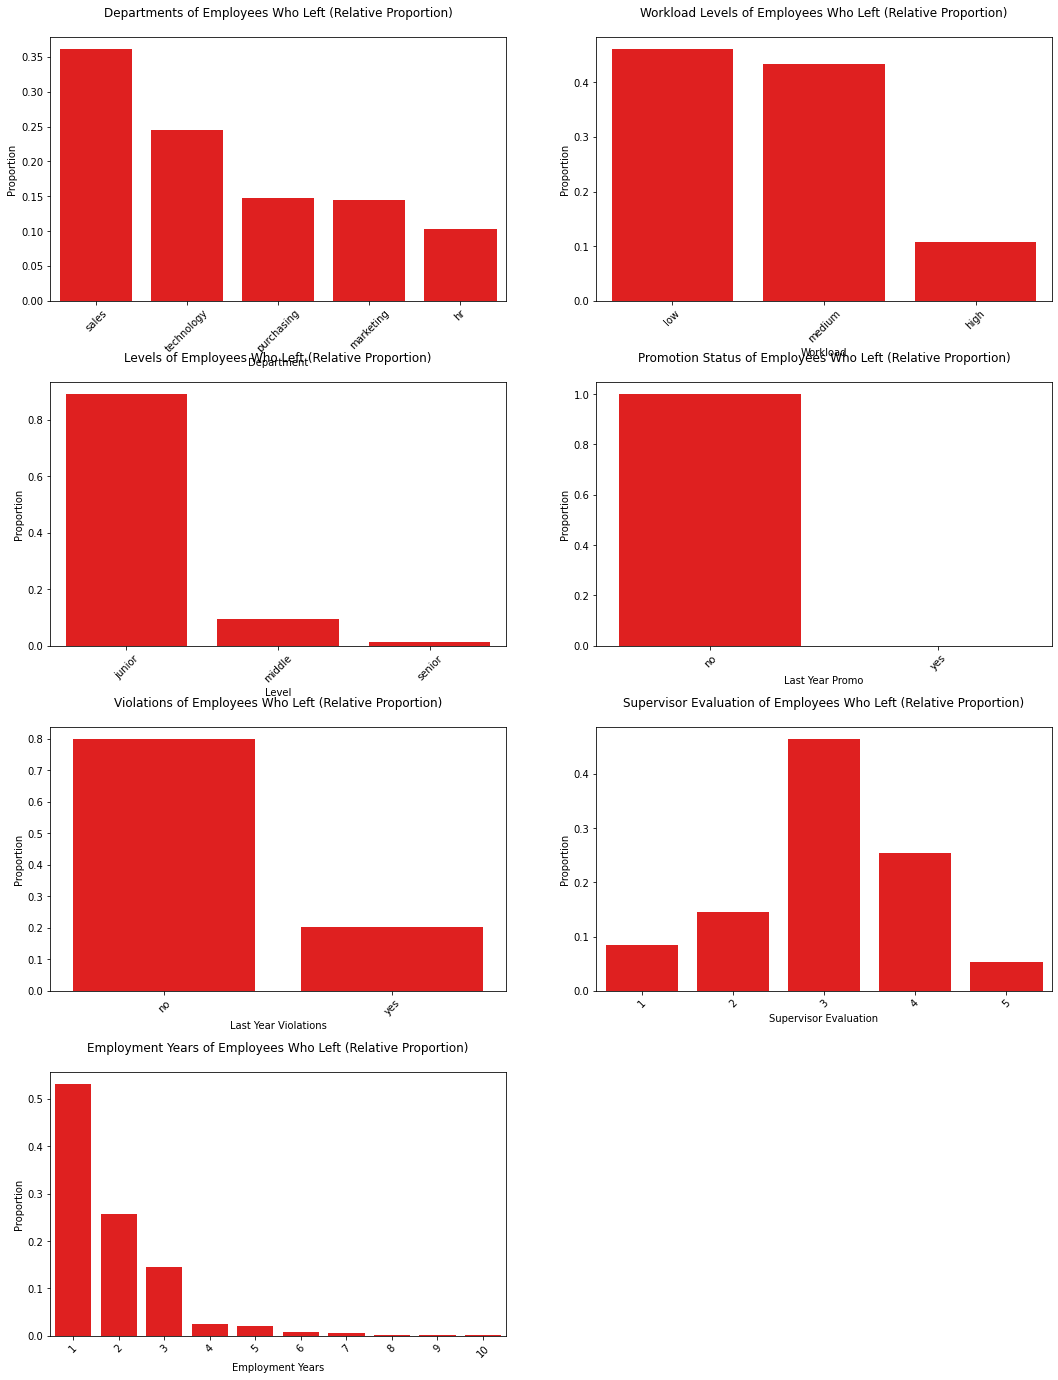

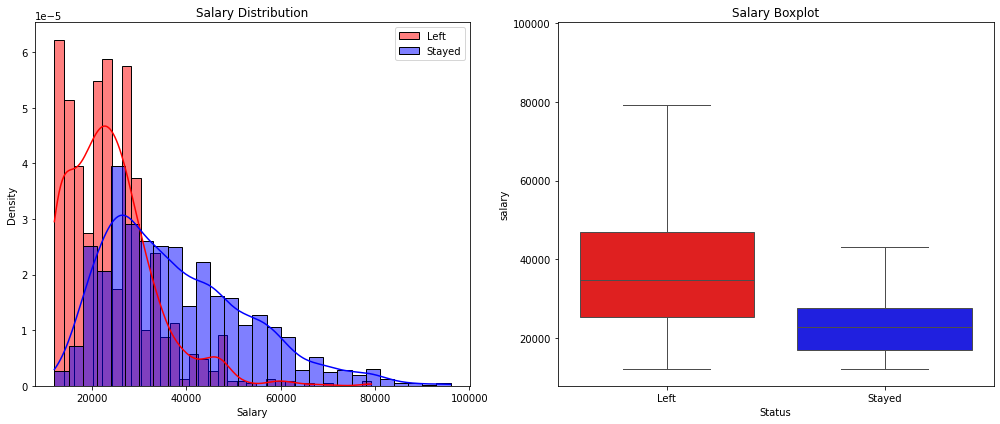

In [143]:
# напишем функцию для построения графиков распределения
def plot_distribution(data, column, title, xlabel, ax):
    distribution = data[column].value_counts(normalize=True).reset_index()
    distribution.columns = [column, 'proportion']
    
    sns.barplot(data=distribution, x=column, y='proportion', color='red', ax=ax)
    ax.set_title(title, pad=20)  # Увеличение отступа для заголовка
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Proportion')
    ax.tick_params(axis='x', rotation=45)

# построим графики
fig, axes = plt.subplots(4, 2, figsize=(16, 20))
fig.tight_layout(pad=6.0) 

plot_distribution(left_employees, 'dept', 'Departments of Employees Who Left (Relative Proportion)', 'Department', axes[0, 0])
plot_distribution(left_employees, 'workload', 'Workload Levels of Employees Who Left (Relative Proportion)', 'Workload', axes[0, 1])
plot_distribution(left_employees, 'level', 'Levels of Employees Who Left (Relative Proportion)', 'Level', axes[1, 0])
plot_distribution(left_employees, 'last_year_promo', 'Promotion Status of Employees Who Left (Relative Proportion)', 'Last Year Promo', axes[1, 1])
plot_distribution(left_employees, 'last_year_violations', 'Violations of Employees Who Left (Relative Proportion)', 'Last Year Violations', axes[2, 0])
plot_distribution(left_employees, 'supervisor_evaluation', 'Supervisor Evaluation of Employees Who Left (Relative Proportion)', 'Supervisor Evaluation', axes[2, 1])
plot_distribution(left_employees, 'employment_years', 'Employment Years of Employees Who Left (Relative Proportion)', 'Employment Years', axes[3, 0])

#построим графики зарплат
axes[3, 1].set_visible(False) 

plt.figure(figsize=(14, 6))

# построим нормированные гистограммы распределения зарплат
plt.subplot(1, 2, 1)
sns.histplot(left_employees['salary'], kde=True, stat='density', color='red', label='Left', common_norm=False)
sns.histplot(stayed_employees['salary'], kde=True, stat='density', color='blue', label='Stayed', common_norm=False)
plt.title('Salary Distribution')
plt.xlabel('Salary')
plt.ylabel('Density')
plt.legend()

# построим боксплот зарплат
plt.subplot(1, 2, 2)
sns.boxplot(x='quit', y='salary', data=train_quit, hue='quit', fliersize=0, palette=['red', 'blue'])
plt.xticks([0, 1], ['Left', 'Stayed'])
plt.title('Salary Boxplot')
plt.xlabel('Status')

plt.tight_layout()
plt.show()

In [144]:
# выведем средние зарплаты
avg_salary_left = left_employees['salary'].mean()
avg_salary_stayed = stayed_employees['salary'].mean()
print(f"Средняя зарплата уволившихся сотрудников: {avg_salary_left:.2f}")
print(f"Средняя зарплата оставшихся сотрудников: {avg_salary_stayed:.2f}")

Средняя зарплата уволившихся сотрудников: 23885.11
Средняя зарплата оставшихся сотрудников: 37702.23


Согласно полученным графикам, сотрудники, которые покинули компанию были сотрудниками отдела продаж 35% (но это также и самая многочисленная группа изначально), потом идут работники отдела технологии (25%), маркетинга(ок 15%) и закупок (ок 15%). Как ни странно большинство ушедших сотрудников оценило свою нагрузку как низкую (ок 45%...может им стало скучно?), затем идут работники со средней загрузкой (ок 42%), и меньше всего уволившихся среди сотрудников с высокой загрузкой (ок 13%). Ок 85% покинувших компанию - это сотрудники уровня junior, 10%- middle и 5% - senior. Почти все уволившиеся не получали продвижения по карьерной лестнице в течение последнего года. 80% уволившихся не нарушали трудовой договор, 20%  - нарушали. У 50% среди уволившихся средняя оценка качества работы супервизором была 3, у 25% - 4, 15% - 2, 8% - 1 и у оставшихся -5. Около 55% уволившихся проработали в компании всего 1 год, 25% - 2, 15% - 3 и так далее. Если сравнивать среднюю заработную плату, то у уволившихся она значительно меньше.

### Визуализация распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников

Далее проведем анализ распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников по test выборке - для этого по id в новую выборку нужно соединить целевые признаки обеих задач.

In [145]:
# соединим данные
data_merged = pd.merge(test_job, test_target_quit, on='id', how='inner')

In [146]:
#выведем на экран первые 5 строк полученного датафрейма
data_merged.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79,no
1,686555,hr,junior,medium,1,no,no,4,30000,0.72,no
2,467458,sales,middle,low,5,no,no,4,19200,0.64,no
3,418655,sales,middle,low,6,no,no,4,19200,0.60,no
4,789145,hr,middle,medium,5,no,no,5,40800,0.75,no


In [147]:
data_merged.shape

(2000, 11)

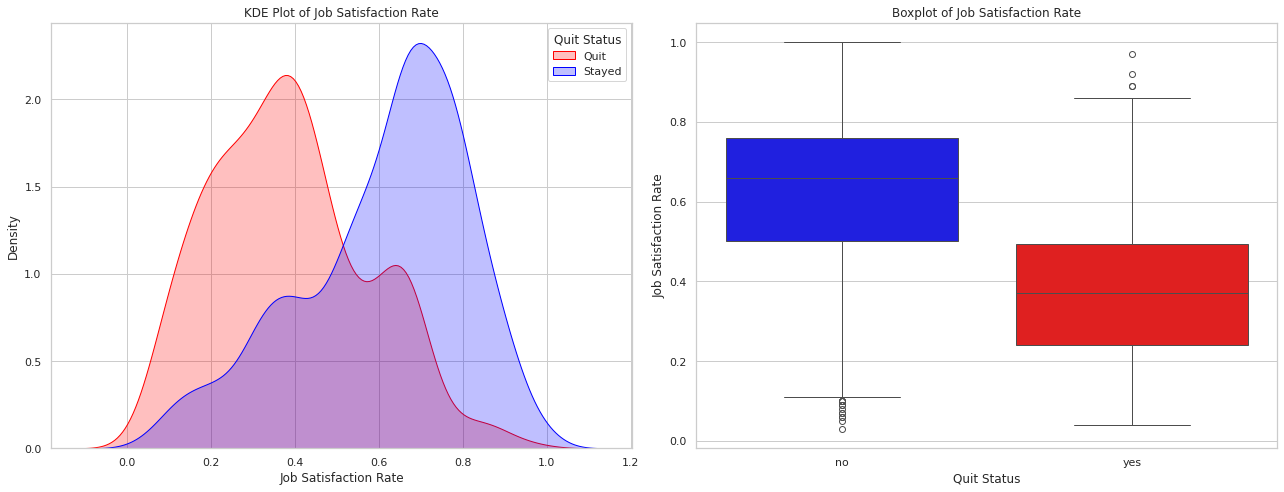

In [148]:
# настроим стиль графиков
sns.set(style="whitegrid")

# создадим фигуру и два subplot
fig, axs = plt.subplots(1, 2, figsize=(18, 7))

# построим KDE плотности распределения на первом subplot
sns.kdeplot(data=data_merged[data_merged['quit'] == 'yes'], x='job_satisfaction_rate', color='red', fill=True, label='Quit', ax=axs[0])
sns.kdeplot(data=data_merged[data_merged['quit'] == 'no'], x='job_satisfaction_rate', color='blue', fill=True, label='Stayed', ax=axs[0])
axs[0].set_title('KDE Plot of Job Satisfaction Rate')
axs[0].set_xlabel('Job Satisfaction Rate')
axs[0].set_ylabel('Density')
axs[0].legend(title='Quit Status')

# построим boxplot на втором subplot, используя hue и отключив легенду
sns.boxplot(x='quit', y='job_satisfaction_rate', hue='quit', data=data_merged, palette={'yes': 'red', 'no': 'blue'}, ax=axs[1], dodge=False)
axs[1].set_title('Boxplot of Job Satisfaction Rate')
axs[1].set_xlabel('Quit Status')
axs[1].set_ylabel('Job Satisfaction Rate')

# Выведем графики на экран
plt.tight_layout()
plt.show()

Как и ожидалось, уровень удовлетворенности у сотрудников, которые покинули компанию, ниже, чем у тех, кто остался

Добавление статистического теста, такого как t-тест, для сравнения распределений двух выборок поможет более объективно подтвердить разницу между ними. 

Сформулируем наши гипотезы. Нулевая гипотеза (H₀): Уровень удовлетворенности работой у ушедших сотрудников равен уровню удовлетворенности у оставшихся сотрудников. Это предполагает, что нет статистически значимой разницы между двумя группами. Альтернативная гипотеза (H₁): уровень удовлетворенности работой у ушедших сотрудников отличается от уровня удовлетворенности у оставшихся сотрудников. Это предполагает, что есть статистически значимая разница между двумя группами.

In [149]:
# Разделим данные на две группы: ушедшие и оставшиеся сотрудники
quit_group = data_merged[data_merged['quit'] == 'yes']['job_satisfaction_rate']
stay_group = data_merged[data_merged['quit'] == 'no']['job_satisfaction_rate']

# Проведем независимый t-тест
t_stat, p_value = ttest_ind(quit_group, stay_group)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("Есть статистически значимая разница в уровне удовлетворенности между ушедшими и оставшимися сотрудниками.")
else:
    print("Нет статистически значимой разницы в уровне удовлетворенности между ушедшими и оставшимися сотрудниками.")

T-statistic: -23.074784903634534
P-value: 1.231122066517193e-104
Есть статистически значимая разница в уровне удовлетворенности между ушедшими и оставшимися сотрудниками.


Результаты t-теста показывают, что t-статистика равна -23.07, а p-value составляет 1.23e-104. Это крайне маленькое значение p-value, что указывает на наличие статистически значимой разницы в уровне удовлетворенности между ушедшими и оставшимися сотрудниками. Результаты t-теста подтверждают, что нулевая гипотеза отвергается. Таким образом, можно с высокой степенью уверенности утверждать, что уровень удовлетворенности работой действительно влияет на вероятность увольнения сотрудников.

### Добавление нового входного признака

Теперь предскажем уровень удовлетворенности сотрудников с помощью нашей первой модели

In [150]:
#предскажем job_satisfaction_rate для нового датафрейма train_quit
y_train_pred = grid_search.best_estimator_.predict(train_quit)

In [151]:
#предскажем job_satisfaction_rate для нового датафрейма train_quit
y_test_pred = grid_search.best_estimator_.predict(test_quit)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [152]:
#добавим предсказанные значения в тренировочные и тестовые данные второй задачи
train_quit['predicted_job_satisfaction_rate'] = y_train_pred

In [153]:
#добавим предсказанные значения в тренировочные и тестовые данные второй задачи
test_quit['predicted_job_satisfaction_rate'] = y_test_pred

In [154]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,predicted_job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.600000
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.853529
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.326667
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.340000
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.804444


## Корреляционный анализ

Теперь рассмотрим взаимосвязи между признаками в датасете train_quit

In [155]:
data_train2 = train_quit.drop(['id'], axis=1)

In [156]:
#список непрерывных признаков
interval_cols2 = ['salary', 'predicted_job_satisfaction_rate']

In [157]:
# построим матрицу корреляций в том числе и для категориальных признаков с помощью phik_matrix() 
data_train2.phik_matrix(interval_cols=interval_cols2) 

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,predicted_job_satisfaction_rate
dept,1.000000,0.000000,0.000000,0.000000,0.000000,0.044274,0.042772,0.280300,0.000000,0.203716
level,0.000000,1.000000,0.479480,0.692676,0.110585,0.000000,0.007189,0.745104,0.312799,0.201826
workload,0.000000,0.479480,1.000000,0.213013,0.044388,0.014063,0.000000,0.793876,0.132243,0.140357
employment_years,0.000000,0.692676,0.213013,1.000000,0.156494,0.000000,0.000000,0.491915,0.659093,0.449126
last_year_promo,0.000000,0.110585,0.044388,0.156494,1.000000,0.000000,0.032376,0.215043,0.157370,0.449389
last_year_violations,0.044274,0.000000,0.014063,0.000000,0.000000,1.000000,0.179228,0.086087,0.185071,0.590938
supervisor_evaluation,0.042772,0.007189,0.000000,0.000000,0.032376,0.179228,1.000000,0.055330,0.245489,0.783040
salary,0.280300,0.745104,0.793876,0.491915,0.215043,0.086087,0.055330,1.000000,0.564154,0.259871
quit,0.000000,0.312799,0.132243,0.659093,0.157370,0.185071,0.245489,0.564154,1.000000,0.523549
predicted_job_satisfaction_rate,0.203716,0.201826,0.140357,0.449126,0.449389,0.590938,0.783040,0.259871,0.523549,1.000000


<Axes: >

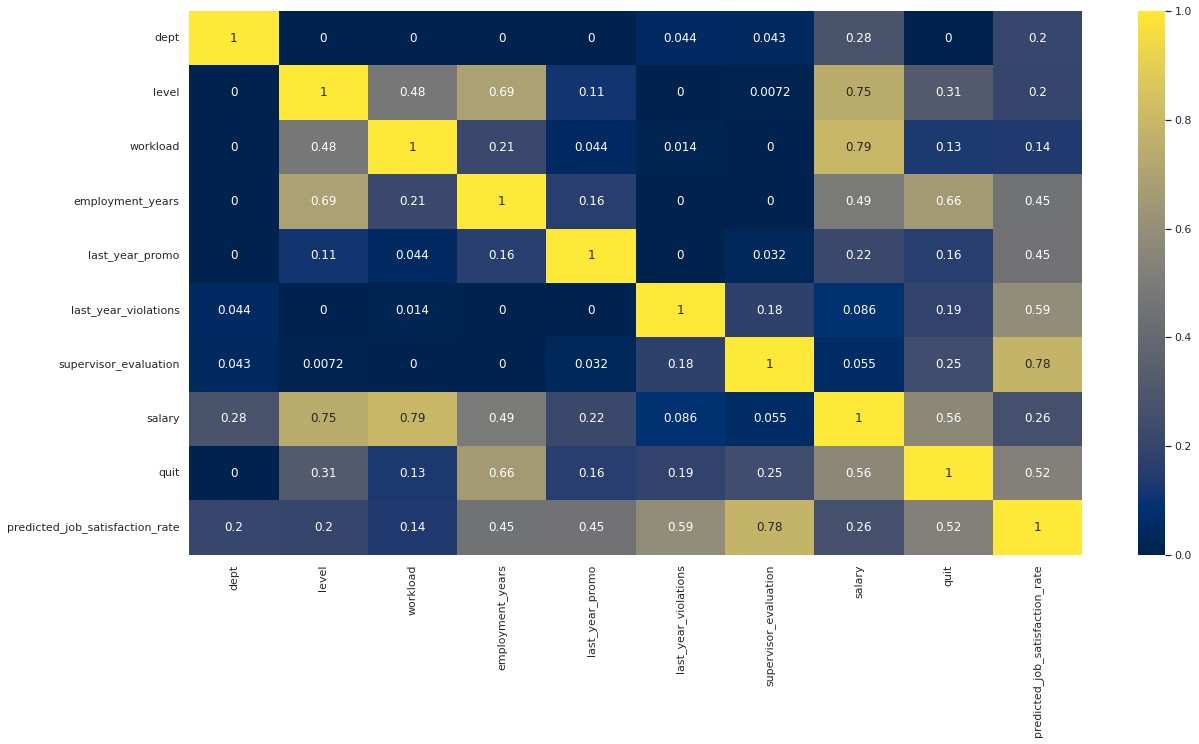

In [158]:
#визуализируем полученную матрицу
plt.figure(figsize=(20,10))
sns.heatmap(data_train2.phik_matrix(interval_cols=interval_cols2), annot=True, cmap='cividis')

Наша целевая переменная quit, имеет высокую корреляцию с 'employment_years' (0.66), 'predicted_job_satisfaction_rate'(0.56), затем с salary (0.56), level(0.31) и supervisor_evalution (0.25).

Тоже самое проверим и с данными test_quit

In [159]:
data_test2 = test_quit.drop(['id'], axis=1)

In [160]:
# построим матрицу корреляций в том числе и для категориальных признаков с помощью phik_matrix() 
data_test2.phik_matrix(interval_cols=interval_cols2) 

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,predicted_job_satisfaction_rate
dept,1.000000,0.000000,0.032472,0.000000,0.000000,0.000000,0.020219,0.238060,0.000000,0.161381
level,0.000000,1.000000,0.196737,0.689666,0.118258,0.017527,0.000000,0.748998,0.293623,0.209199
workload,0.032472,0.196737,1.000000,0.167397,0.082891,0.000000,0.008174,0.739462,0.253097,0.099805
employment_years,0.000000,0.689666,0.167397,1.000000,0.173637,0.066371,0.000000,0.494701,0.605927,0.459216
last_year_promo,0.000000,0.118258,0.082891,0.173637,1.000000,0.000000,0.011704,0.193727,0.137762,0.497658
last_year_violations,0.000000,0.017527,0.000000,0.066371,0.000000,1.000000,0.189719,0.000000,0.174740,0.589413
supervisor_evaluation,0.020219,0.000000,0.008174,0.000000,0.011704,0.189719,1.000000,0.114588,0.294738,0.783508
salary,0.238060,0.748998,0.739462,0.494701,0.193727,0.000000,0.114588,1.000000,0.508308,0.275573
quit,0.000000,0.293623,0.253097,0.605927,0.137762,0.174740,0.294738,0.508308,1.000000,0.563116
predicted_job_satisfaction_rate,0.161381,0.209199,0.099805,0.459216,0.497658,0.589413,0.783508,0.275573,0.563116,1.000000


<Axes: >

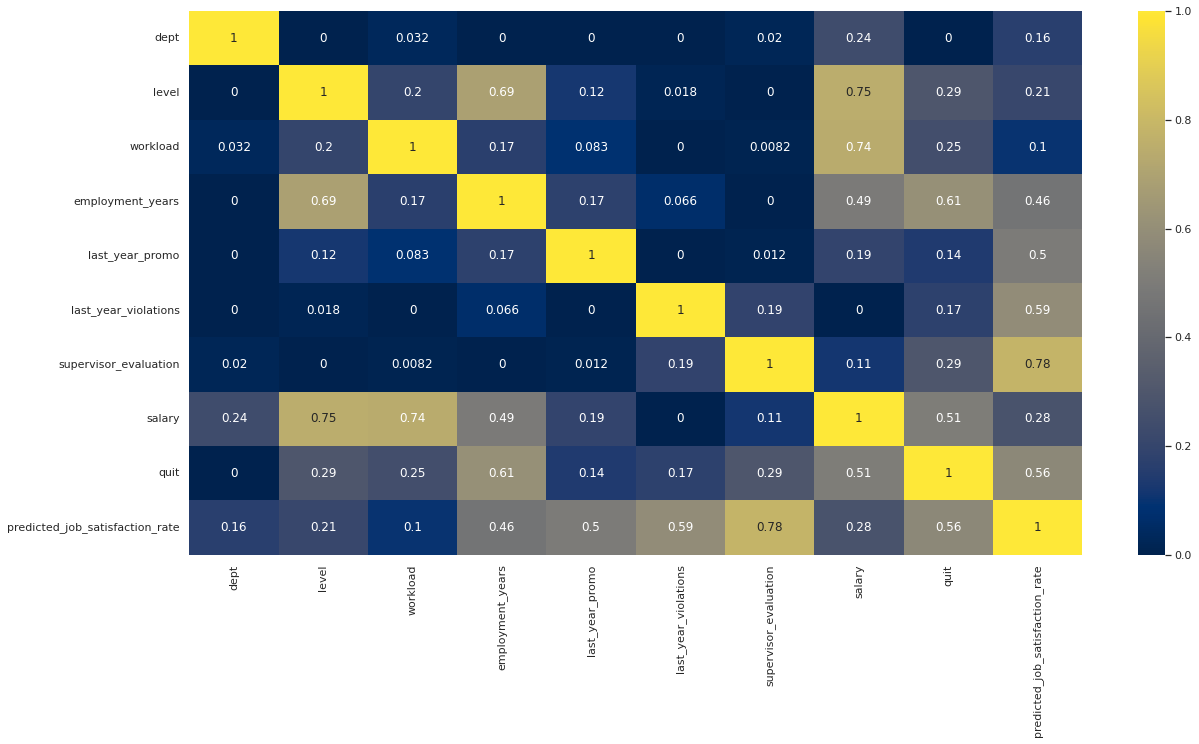

In [161]:
#визуализируем полученную матрицу
plt.figure(figsize=(20,10))
sns.heatmap(data_test2.phik_matrix(interval_cols=interval_cols2), annot=True, cmap='cividis')

Наша целевая переменная quit, имеет также как и в датасете data_train высокую корреляцию с 'employment_years' (0.61), 'predicted_job_satisfaction_rate'(0.61), затем с salary (0.51), level(0.29) и supervisor_evalution (0.29).

In [162]:
#проверим наличие дубликатов после удаления id для train выборки
data_train2.duplicated().sum()

1413

In [163]:
data_train2 = data_train2.drop_duplicates().reset_index(drop = True)

In [164]:
#проверим наличие дубликатов после удаления id для train выборки
data_train2.duplicated().sum()

0

## Построение паплайна

Напишем наш паплайн

In [165]:
RANDOM_STATE = 42
#определим наши обучающую и тестовую выборки
X_train2 = data_train2.drop(['quit'], axis=1)
y_train2 = data_train2['quit']
X_test2 = data_test2.drop(['quit'], axis=1)
y_test2 = data_test2['quit']
X_train2.shape, X_test2.shape

((2587, 9), (2000, 9))

In [166]:
#закодируем целевую переменную
encoder = LabelEncoder()
y_train_encoded2 = encoder.fit_transform(y_train2)
y_test_encoded2 = encoder.transform(y_test2)

Далее обозначим, какие данные требуют масштабирования, а какие — кодирования.

При кодировании, для признаков у которых есть определенный порядок/иерархия мы используем OrdinalEncoder. В нашем датасете это будет: level, workload. Признаки dept, last_year_promo, last_year_violations мы закодируем с помощью OneHotEncoder

In [167]:
# создаём списки с названиями признаков
ohe_columns = ['dept', 'last_year_violations','last_year_promo']  
ord_columns = ['level', 'workload']  

In [168]:
num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'predicted_job_satisfaction_rate']

При кодировании неизвестных категорий могут возникнуть пропуски. Обработать их поможет инструмент SimpleImputer, который заменит недостающие значения в данном случае на моду.

In [169]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

In [170]:
# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'],
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [171]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough', force_int_remainder_cols=False
)

In [172]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])
param_grid= [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range (1, 30),
        'models__max_features': range(1, 30),
        'models__min_samples_split': [2, 5, 10],
        'models__min_samples_leaf': [1, 2, 4],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range (1, 30),
        'models__weights': ['uniform', 'distance'],
        'models__p': [1, 2],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE
        )],
        'models__penalty': ['l1', 'l2'],
        'models__solver': ['liblinear', 'saga'],
        'models__C': range(1, 30),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    {
        'models': [SVC(
            random_state=RANDOM_STATE, probability=True
        )],
        'models__C': range(1, 20),
        'models__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

Теперь задача стоит определиться с метрикой, подходящей для нашей задачи. 

In [173]:
# Инициализация RandomizedSearchCV
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=StratifiedKFold(n_splits=5),
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

In [174]:
# Обучение модели
randomized_search.fit(X_train2, y_train_encoded2)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(force_int_remainder_cols=False,
                                                                remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='igno...
                                         'models__penalty': ['l1', 'l2'],
                                         'models__solver': ['liblinear',
                                                            'saga'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(probability=True,
                                                        random_state=42)],
                                         'models__C': range(1, 20),
                                         'models__kernel': ['linear', 'poly',
                                                            'rbf', 'sigmoid'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [175]:
print('Метрика ROC_AUC для лучшей модели:\n', randomized_search.best_score_)
print('\nЛучшая модель и её параметры:\n\n', randomized_search.best_estimator_) 

Метрика ROC_AUC для лучшей модели:
 0.8950325468155264

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept',
                                                   'last_y

Таким образом, лучшей моделью, предсказывающей уволится сотрудник или нет, оказалась модель DecisionTreeClassifier с параметрами: max_depth=6, max_features=19, min_samples_leaf=4, min_samples_split=10, random_state=42. Метрика ROC_AUC для лучшей модели: 0.895. Достаточно неплохо

In [176]:
# Рассчитаем вероятности на тестовых данных
y_test_proba2 = randomized_search.predict_proba(X_test2)[:, 1]  # Предсказания вероятности для класса 1

# Оценим метрику ROC AUC
print(f'Метрика ROC AUC на тестовой выборке: {roc_auc_score(y_test_encoded2, y_test_proba2)}')

Метрика ROC AUC на тестовой выборке: 0.9211912769908532


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Метрика ROC_AUC на тестовой выборке: 0.921. Критерий успеха: 'ROC-AUC ≥0.91 на тестовой выборке' выполнен

Попробуем посмотреть на значения смещения и разброса, что бы посмотреть в чем может быть проблема

In [177]:
#оценим модели с помощью кросс-валидации
cv_scores = cross_val_score(
    randomized_search.best_estimator_,
    X_train2, 
    y_train_encoded2, 
    cv=StratifiedKFold(n_splits=5), 
    scoring='roc_auc'
)

# рассчитаем смещение - среднее значение ROC-AUC
bias = np.mean(cv_scores)

# рассчитаем разброс - стандартное отклонение ROC-AUC
variance = np.std(cv_scores)

print(f'Смещение (bias): {bias}')
print(f'Разброс (variance): {variance}')

Смещение (bias): 0.8950325468155264
Разброс (variance): 0.018151722297268108


Смещение больше чем разброс - значит модель недообучилась. Эту проблему можно решить, усложнив алгоритм: добавив нелинейность или увеличив пространство признаков. Также стоит увеличить выборку или расширить признаковое описание, если это возможно. Скорее всего, модели не хватает данных, чтобы уловить все закономерности.

Далее сравним нашу лучшую модель с константной моделью

In [178]:
dummy_model2 = DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE)
dummy_model2.fit(X_train2, y_train_encoded2)

#посмотрим на предсказания константной модели на тестовых данных
y_dummy_pred2 = dummy_model2.predict(X_test2)
y_dummy_proba2 = dummy_model2.predict_proba(X_test2)[:, 1] 

#оценим качество константной модели
dummy_roc_auc2 = roc_auc_score(y_test_encoded2, y_dummy_pred2)
print(f'Метрика ROC-AUC для константной модели: {dummy_roc_auc2}')

Метрика ROC-AUC для константной модели: 0.5


Наша лучшая модель значительно превосходит константную модель, что подтверждает, что все усилия по созданию новых признаков, тюнингу и кросс-валидации оправданы. Это также подтверждает, что наша модель вносит существенный вклад в улучшение качества предсказаний по сравнению с простым подходом.

Посмотрим на важность наших признаков

In [179]:
best_pipeline = randomized_search.best_estimator_
best_model = best_pipeline.named_steps['models']

In [180]:
preprocessor = best_pipeline.named_steps['preprocessor']

In [181]:
#преобразуем X_test_transformed
X_test_transformed2 = preprocessor.transform(X_test2)
X_train_transformed2 = preprocessor.transform(X_train2)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [182]:
# Получение важностей признаков
feature_importances = best_model.feature_importances_

# Создание DataFrame для важностей признаков
feature_names = np.array(preprocessor.get_feature_names_out())
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Score': feature_importances
}).sort_values(by='Score', ascending=False)

In [183]:
feature_importances_df

,Feature,Score
6,ord__level,0.467462
11,num__predicted_job_satisfaction_rate,0.278482
8,num__employment_years,0.088371
7,ord__workload,0.084295
10,num__salary,0.057963
9,num__supervisor_evaluation,0.014891
3,ohe__dept_technology,0.003042
1,ohe__dept_purchasing,0.002455
2,ohe__dept_sales,0.001857
4,ohe__last_year_violations_yes,0.001183


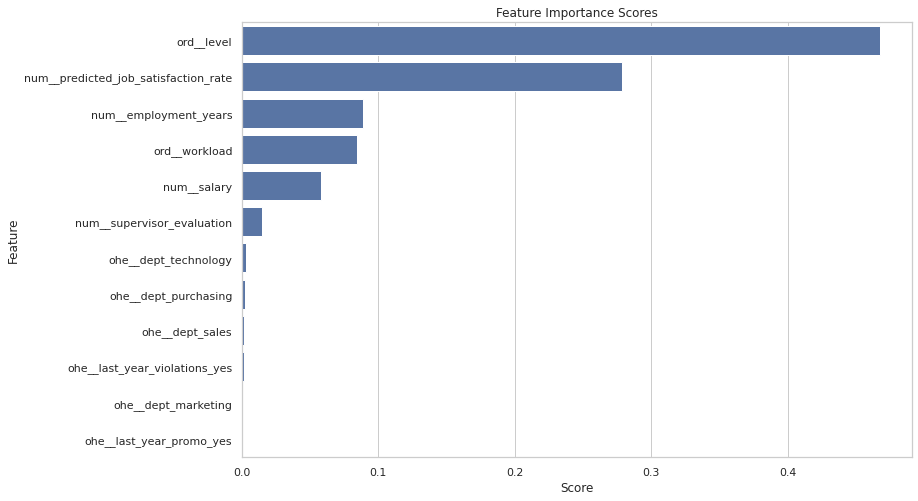

In [184]:
# Нарисуем график без указания палитры
plt.figure(figsize=(12, 8))
sns.barplot(x='Score', y='Feature', data=feature_importances_df)
plt.title('Feature Importance Scores')
plt.xlabel('Score')
plt.ylabel('Feature')
plt.show()

Признак, соответствующий уровню должности (ord__level), является самым важным фактором в модели, с наибольшей оценкой важности 0.387953. Следующим по важности идет признак, связанный с оценкой руководителя (num__supervisor_evaluation) с оценкой 0.285650. Зарплата (num__salary) также оказывает значительное влияние, с оценкой 0.150236. Количество лет стажа (num__employment_years) имеет умеренную важность, с оценкой 0.112882. Остальные признаки, такие как рабочая нагрузка (ord__workload), нарушения за последний год (ohe__last_year_violations_yes), отделы (например, ohe__dept_technology, ohe__dept_marketing) и получение продвижения в прошлом году (ohe__last_year_promo_yes), имеют относительно низкую важность, менее 0.03, что указывает на их меньший вклад в модель.

In [185]:
background_data = shap.kmeans(X_test_transformed2, 100)

In [186]:
explainer = shap.KernelExplainer(best_model.predict_proba, background_data)
shap_values = explainer.shap_values(X_test_transformed2)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [187]:
probabilities = best_model.predict_proba(X_test_transformed2[:1])
print(probabilities)

[[0.70967742 0.29032258]]


In [188]:
best_model.predict_proba

<bound method DecisionTreeClassifier.predict_proba of DecisionTreeClassifier(max_depth=6, max_features=19, min_samples_leaf=4,
                       min_samples_split=10, random_state=42)>

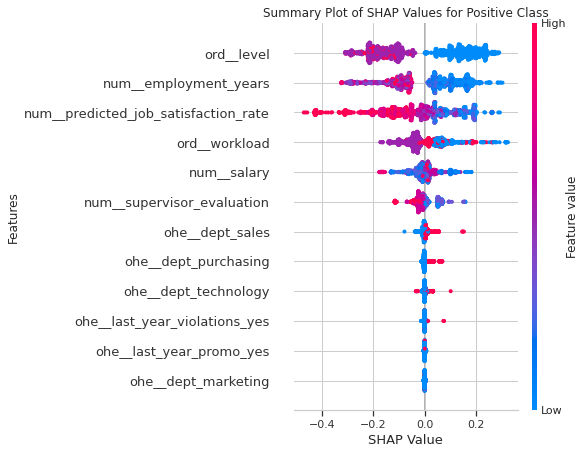

In [189]:
if isinstance(shap_values, list):
    # Получим SHAP значения для позитивного класса
    # SHAP значения для класса 1 (позитивный)
    shap_values_pos_class = shap_values[1]  
else:
    # Если shap_values это не список, возможно, это numpy array
    shap_values_pos_class = shap_values[:, :, 1]  

# Создаём фигуру и оси вручную
fig, ax = plt.subplots(figsize=(12, 8))  

# Выполним визуализацию SHAP
shap.summary_plot(shap_values_pos_class, X_test_transformed2, feature_names=feature_names, show=False)

# Получаем текущие оси
current_ax = plt.gca()

# Добавляем подписи и заголовок
current_ax.set_xlabel('SHAP Value') 
current_ax.set_ylabel('Features')    
current_ax.set_title('Summary Plot of SHAP Values for Positive Class')  

# Показываем график
plt.show()

Согласно графику, низкие значения признака level/уровня занимаемой должности, employment_years/срока службы сотрудника, уровня удовлетворенности сотрудника/predicted_job_satisfaction_rate' повышают вероятность того, что сотрудник уйдет из компании. И наоборот. Признаки, такие как нарушения за последний год (ohe__last_year_violations_yes), отделы (например, ohe__dept_technology, ohe__dept_marketing) и получение продвижения в прошлом году (ohe__last_year_promo_yes), имеют относительно низкую важность, что указывает на их меньший вклад в модель.

*Промежуточный вывод* 

Таким образом, полученная лучшая модель достигла ROC AUC = 0.892 на обучающих данных и 0.917 на тестовых данных. ROC_AUC для константной модели: 0.5, что подтверждает, что модель DecisionTreeClassifier значительно превосходит простую константную модель и приносит реальную пользу.
Самые важные признаками оказались уровень должности (ord__level), оценка супервизора (num__supervisor_evaluation), и зарплата (num__salary). Эти признаки имеют наибольшее влияние на предсказания модели. Менее важные признаки: Рабочая нагрузка (ord__workload), нарушения за последний год (ohe__last_year_violations_yes), и отделы (ohe__dept_). Эти признаки имеют меньший вклад, что указывает на их ограниченную роль в предсказаниях.

# Вывод

Целью данного анализа была разработка моделей для предсказания уровня удовлетворённости сотрудников и вероятности их увольнения, что поможет компании оптимизировать управление персоналом и снизить риски, связанные с оттоком сотрудников. Мы провели анализ данных, построили модели и выбрали лучшие из них для выполнения поставленных задач.
Проведенные этапы работы. Мы загрузили данные из предоставленных файлов, содержащих информацию о сотрудниках и их удовлетворённости, а также данные о возможном увольнении сотрудников. Мы исследовали данные на наличие пропусков, аномалий и других особенностей. Выполнили необходимую предобработку, включая заполнение пропусков и очистку данных. Провели анализ распределений признаков, визуализировали взаимосвязи между ними и оценили важность различных факторов для целевых переменных. Внедрили пайплайн для подготовки данных, включая масштабирование и кодирование признаков. Мы использовали как минимум два кодировщика для обработки категориальных и числовых признаков. 
Далее мы обучили и оптимизировали несколько моделей, включая линейную модель и дерево решений. Для подбора гиперпараметров использовали GridSearchCV и оценивали модели по метрике SMAPE для первой задачи и  RandomizedSearchCV с ROC AUC для второй задачи. Для первой задачи выбрана модель DecisionTreeRegressor с гиперпараметрами max_depth=13, max_features=8, min_samples_split=8, random_state=42. Модель показала отличные результаты на тестовой выборке с метрикой SMAPE ≤ 15, что подтвердило её способность эффективно предсказывать уровень удовлетворённости сотрудников.
Для второй задачи лучшей моделью оказалась лучшей моделью, предсказывающей уволится сотрудник или нет, оказалась модель DecisionTreeClassifier с параметрами: max_depth=6, max_features=19, min_samples_leaf=4, min_samples_split=10, random_state=42. Модель достигла ROC AUC = 0.895 на обучающих данных и 0.92 на тестовых данных, что указывает на её высокую эффективность в предсказании увольнений.

**Рекомендации бизнесу:**

Поскольку модель, предсказывающая уровень удовлетворённости, демонстрирует высокую точность, компания может использовать её для более целенаправленного проведения опросов и улучшения рабочих условий, что поможет снизить уровень увольнений. Важно обращать внимание на признаки, которые имеют наибольшее влияние на удовлетворённость и увольнения сотрудников, такие как оценка супервизора, уровень должности и зарплата. Это позволит компании сосредоточиться на улучшении этих аспектов.
Рекомендуется регулярно пересматривать и обновлять модели предсказания, чтобы учитывать изменения в данных и поддерживать их актуальность и точность.
Рекомендуется продолжить исследование факторов, влияющих на увольнения, и изучить дополнительные признаки, которые могут улучшить качество предсказаний.
Эти рекомендации помогут компании более эффективно управлять персоналом, снизить риски связанных с увольнениями и повысить общую удовлетворённость сотрудников.